# Generate a plot of multiple SEDs

In [1]:
%load_ext autoreload
%autoreload 2

import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import syncfit

VLA_nus = np.linspace(0.11,50) #GHz
ALMA_nus = np.linspace(35, 950) # GHz

In [2]:
def row_to_val(row, key='Flux Density'):
    if '<' in row[key]:
        return float(row[key].replace(' ','')[1:])
    return float(row[key].split('+')[0])

def row_to_err(row, key='Flux Density'):
    if '<' in row[key]:
        return 0
    return float(row[key].split('-')[-1])

def is_upperlimit(row, key='Flux Density'):
    if '<' in row[key]:
        return True
    return False

def get_facility(row):
    if '-' in row['Array Configuration']:
        return 'ALMA'
    return 'VLA'

def label(row, obj_name):
    # if row.t < 100: # if the time is less than 100 days
    #     # this is an "early time" observation
    #     return obj_name+r' ($\Delta t < 100$ days)'
    return obj_name#+r' ($\Delta t > 100$ days)'

In [3]:
# First Sw J1644+57
SwJ1644_files = glob.glob('SwJ1644+57*')

allswfiles = []
cite_map = {'Berger2012':'Berger et al. (2012)',
            'Zauderer2013': 'Zauderer et al. (2013)',
            'Eftekhari2018': 'Eftekhari et al. (2018)'}
for f in SwJ1644_files:
    df = pd.read_csv(f, sep='\t') 
    for c in cite_map.keys():
        if c in f:
            df['Citation'] = [cite_map[c]]*len(df)
            continue

    allswfiles.append(df)
    
SwJ1644_data = pd.concat(allswfiles)
SwJ1644_data.Facility = SwJ1644_data.Facility.fillna('VLA') # all of these observations were with the VLA

# clean the data
del SwJ1644_data['Unnamed: 4']
del SwJ1644_data['Unnamed: 3']
SwJ1644_data = SwJ1644_data.drop(0)

SwJ1644_data['FluxDensity'] = SwJ1644_data.apply(row_to_val, axis=1)
SwJ1644_data['FluxDensityErr'] = SwJ1644_data.apply(row_to_err, axis=1)

del SwJ1644_data['Flux Density']

SwJ1644_data.Frequency = SwJ1644_data.Frequency.astype(float)
SwJ1644_data.t = SwJ1644_data.t.astype(float)


ts = SwJ1644_data.t.unique()
m, M = int(ts.min()), int(ts.max())

vals = np.logspace(np.log10(m),np.log10(M), 11, dtype=int)
SwJ1644_data['TimeGroup'] = np.zeros(len(SwJ1644_data))
SwJ1644_data['Object'] = SwJ1644_data.apply(label, obj_name='Sw J1644+57', axis=1)
for idx, row in SwJ1644_data.iterrows():
    
    for val_min, val_max in zip(vals[:-1], vals[1:]):
        if row.t >= val_min and row.t <= val_max:
            SwJ1644_data.TimeGroup[idx] = f'{val_min}-{val_max} days'
            break
            
SwJ1644_data['t'] = SwJ1644_data.t.astype(float)
SwJ1644_data

/tmp/ipykernel_15370/2284446150.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SwJ1644_data.TimeGroup[idx] = f'{val_min}-{val_max} days'
/tmp/ipykernel_15370/2284446150.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '143-273 days' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  SwJ1644_data.TimeGroup[idx] = f'{val_min}-{val_max} days'


,t,Facility,Frequency,Citation,FluxDensity,FluxDensityErr,TimeGroup,Object
1,244.23,JVLA,1.8,Zauderer et al. (2013),2.29,0.08,993-1894 days,Sw J1644+57
2,271.95,JVLA,1.8,Zauderer et al. (2013),2.02,0.23,993-1894 days,Sw J1644+57
3,383.92,JVLA,1.8,Zauderer et al. (2013),4.37,0.10,993-1894 days,Sw J1644+57
4,452.66,JVLA,1.8,Zauderer et al. (2013),3.77,0.09,993-1894 days,Sw J1644+57
5,581.31,JVLA,1.8,Zauderer et al. (2013),2.88,0.08,993-1894 days,Sw J1644+57
...,...,...,...,...,...,...,...,...
48,1029.00,VLA,24.5,Eftekhari et al. (2018),1.15,0.02,993-1894 days,Sw J1644+57
49,1093.00,VLA,24.5,Eftekhari et al. (2018),0.92,0.07,993-1894 days,Sw J1644+57
50,1890.00,VLA,24.5,Eftekhari et al. (2018),0.37,0.06,993-1894 days,Sw J1644+57
51,639.00,VLA,30.0,Eftekhari et al. (2018),1.88,0.09,521-993 days,Sw J1644+57


In [4]:
# Now AT2019dsg
dsg = pd.read_csv('AT2019dsg_Cendes2021.txt', sep=',')

dsg['FluxDensity'] = dsg.apply(row_to_val, axis=1)
dsg['FluxDensityErr'] = dsg.apply(row_to_err, axis=1)
dsg['Upperlimit'] = dsg.apply(is_upperlimit, axis=1)
dsg['Facility'] = dsg.apply(get_facility, axis=1)
dsg['Object'] = dsg.apply(label, obj_name='AT2019dsg', axis=1)

dsg['t'] = dsg.t.astype(float) 
dsg['Citation'] = ['Cendes et al. (2021)']*len(dsg)

dsg

,Date,t,Array Configuration,Frequency,Flux Density,FluxDensity,FluxDensityErr,Upperlimit,Facility,Object,Citation
0,2019 May 24,55.0,B,5.0,0.09 +or- 0.01,0.09,0.01,False,VLA,AT2019dsg,Cendes et al. (2021)
1,2019 May 24,55.0,B,7.0,0.19 +or- 0.01,0.19,0.01,False,VLA,AT2019dsg,Cendes et al. (2021)
2,2019 May 24,55.0,B,13.0,0.48 +or- 0.02,0.48,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
3,2019 May 24,55.0,B,15.0,0.54 +or- 0.02,0.54,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
4,2019 May 24,55.0,B,17.0,0.58 +or- 0.02,0.58,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
...,...,...,...,...,...,...,...,...,...,...,...
57,2020 Jan 24,300.0,D,17.0,0.23 +or- 0.03,0.23,0.03,False,VLA,AT2019dsg,Cendes et al. (2021)
58,2020 Oct 11,561.0,B,1.5,0.35 +or- 0.05,0.35,0.05,False,VLA,AT2019dsg,Cendes et al. (2021)
59,2020 Oct 11,561.0,B,2.6,0.26 +or- 0.02,0.26,0.02,False,VLA,AT2019dsg,Cendes et al. (2021)
60,2020 Oct 11,561.0,B,3.4,0.17 +or- 0.01,0.17,0.01,False,VLA,AT2019dsg,Cendes et al. (2021)


In [5]:
# AT2022cmc

cmc = pd.read_csv('AT2022cmc_Andreoni2022.txt', sep='&')

cmc = cmc.drop(0)
print(cmc[' nu '])
cmc['Frequency'] = cmc[' nu '].astype(float)#
cmc['t'] = cmc[' Delta t '].astype(float)
cmc['FluxDensity'] = cmc.apply(row_to_val, key=' F_nu ', axis=1).astype(float)*1e-3 # convert from uJy to mJy
cmc['FluxDensityErr'] = cmc['  RMS'].astype(float)*1e-3
cmc['Object'] = cmc.apply(label, obj_name='AT2022cmc', axis=1)
cmc['Citation'] = ['Andreoni et al. (2022)']*len(cmc)

cmc

1        8.5
2        9.5
3       10.5
4       11.5
5        8.5
       ...  
121     11.5
122     12.8
123     14.3
124     15.9
125     17.4
Name:  nu , Length: 125, dtype: object


,#Facility,UT date,Delta t,nu,F_nu,RMS,Frequency,t,FluxDensity,FluxDensityErr,Object,Citation
1,VLA,2022-02-15 12:30,4.07,8.5,33,7,8.5,4.07,0.033,0.007,AT2022cmc,Andreoni et al. (2022)
2,VLA,2022-02-15 12:30,4.07,9.5,46,7,9.5,4.07,0.046,0.007,AT2022cmc,Andreoni et al. (2022)
3,VLA,2022-02-15 12:30,4.07,10.5,51,8,10.5,4.07,0.051,0.008,AT2022cmc,Andreoni et al. (2022)
4,VLA,2022-02-15 12:30,4.07,11.5,68,9,11.5,4.07,0.068,0.009,AT2022cmc,Andreoni et al. (2022)
5,VLA,2022-02-16 12:19,5.07,8.5,43,8,8.5,5.07,0.043,0.008,AT2022cmc,Andreoni et al. (2022)
...,...,...,...,...,...,...,...,...,...,...,...,...
121,VLA,2022-03-31 04:13,47.73,11.5,438,14,11.5,47.73,0.438,0.014,AT2022cmc,Andreoni et al. (2022)
122,VLA,2022-03-31 04:23,47.74,12.8,583,12,12.8,47.74,0.583,0.012,AT2022cmc,Andreoni et al. (2022)
123,VLA,2022-03-31 04:23,47.74,14.3,724,12,14.3,47.74,0.724,0.012,AT2022cmc,Andreoni et al. (2022)
124,VLA,2022-03-31 04:23,47.74,15.9,801,14,15.9,47.74,0.801,0.014,AT2022cmc,Andreoni et al. (2022)


# Merge all the data and plot it

In [6]:
def sefd(nu, min_rms=1e-6, npol=1, dt=3600): 
    # from https://leo.phys.unm.edu/~lwa/obsstatus/obsstatus006.html
    return min_rms*np.sqrt(2*npol*nu*dt)*1e3 # calculate and convert from Jy -> mJy

In [7]:
data = pd.concat([SwJ1644_data, dsg, cmc])
data

,t,Facility,Frequency,Citation,FluxDensity,FluxDensityErr,TimeGroup,Object,Date,Array Configuration,Flux Density,Upperlimit,#Facility,UT date,Delta t,nu,F_nu,RMS
1,244.23,JVLA,1.8,Zauderer et al. (2013),2.290,0.080,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,271.95,JVLA,1.8,Zauderer et al. (2013),2.020,0.230,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,383.92,JVLA,1.8,Zauderer et al. (2013),4.370,0.100,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,452.66,JVLA,1.8,Zauderer et al. (2013),3.770,0.090,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,581.31,JVLA,1.8,Zauderer et al. (2013),2.880,0.080,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,47.73,NaN,11.5,Andreoni et al. (2022),0.438,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:13,47.73,11.5,438,14
122,47.74,NaN,12.8,Andreoni et al. (2022),0.583,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,12.8,583,12
123,47.74,NaN,14.3,Andreoni et al. (2022),0.724,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,14.3,724,12
124,47.74,NaN,15.9,Andreoni et al. (2022),0.801,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,15.9,801,14


/tmp/ipykernel_12687/488859305.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avgs = grp.groupby('range').FluxDensity.agg(['min', 'max', 'median'])
/tmp/ipykernel_12687/488859305.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avgs = grp.groupby('range').FluxDensity.agg(['min', 'max', 'median'])
/tmp/ipykernel_12687/488859305.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avgs = grp.groupby('range').Flux

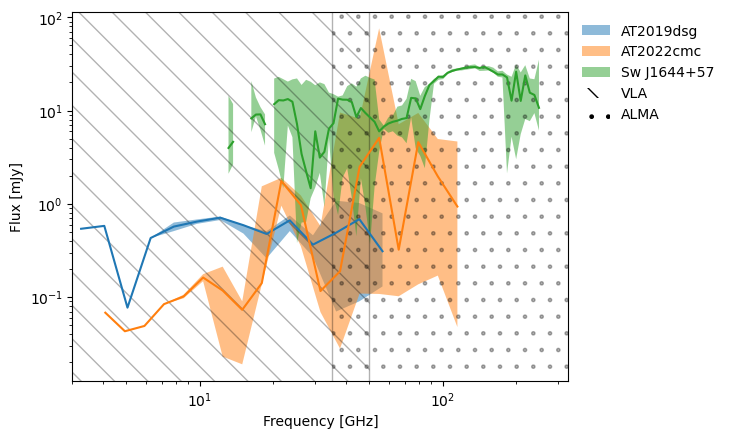

In [8]:
fig, ax = plt.subplots()
bin_factor = 3

for lab, grp in data.groupby('Object'):
    nbins = len(grp)//bin_factor
    bins = np.logspace(np.log10(grp.Frequency.min()), np.log10(grp.Frequency.max()), nbins)
    grp['range'] = pd.cut(grp.index, 
                          bins, 
                          retbins=False)
    avgs = grp.groupby('range').FluxDensity.agg(['min', 'max', 'median'])
    bincenter = list(avgs.index.map(lambda interval: (interval.left+interval.right)/2))
    
    # plot a 2 std region
    ax.fill_between(bincenter, avgs['min'], avgs['max'], alpha=0.5, label=lab)
    ax.plot(bincenter, avgs['median'])

ax.set_xscale('log')
ax.set_yscale('log')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
    
ax.fill_between(VLA_nus, [1e-50]*len(VLA_nus), [1000]*len(VLA_nus), label='VLA', alpha=0.3, facecolor="none", hatch="\\")
ax.fill_between(ALMA_nus, [1e-50]*len(ALMA_nus), [1000]*len(ALMA_nus), label='ALMA', alpha=0.3, facecolor="none", hatch=".",)

ax.set_ylim(*ylim)
ax.set_xlim(3, xlim[1])
ax.set_ylabel('Flux [mJy]')
ax.set_xlabel('Frequency [GHz]')
ax.legend(bbox_to_anchor=(1.32, 1), frameon=False,)

fig.savefig('SEFD-plot.png', transparent=False, bbox_inches='tight')

In [9]:
data

,t,Facility,Frequency,Citation,FluxDensity,FluxDensityErr,TimeGroup,Object,Date,Array Configuration,Flux Density,Upperlimit,#Facility,UT date,Delta t,nu,F_nu,RMS
1,244.23,JVLA,1.8,Zauderer et al. (2013),2.290,0.080,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,271.95,JVLA,1.8,Zauderer et al. (2013),2.020,0.230,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,383.92,JVLA,1.8,Zauderer et al. (2013),4.370,0.100,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,452.66,JVLA,1.8,Zauderer et al. (2013),3.770,0.090,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,581.31,JVLA,1.8,Zauderer et al. (2013),2.880,0.080,993-1894 days,Sw J1644+57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,47.73,NaN,11.5,Andreoni et al. (2022),0.438,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:13,47.73,11.5,438,14
122,47.74,NaN,12.8,Andreoni et al. (2022),0.583,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,12.8,583,12
123,47.74,NaN,14.3,Andreoni et al. (2022),0.724,0.012,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,14.3,724,12
124,47.74,NaN,15.9,Andreoni et al. (2022),0.801,0.014,NaN,AT2022cmc,NaN,NaN,NaN,NaN,VLA,2022-03-31 04:23,47.74,15.9,801,14


# Model the SEDs

  0%|                                                                        | 0/100 [00:00<?, ?it/s]

  3%|█▉                                                              | 3/100 [00:00<00:03, 27.17it/s]

  6%|███▊                                                            | 6/100 [00:00<00:03, 27.53it/s]

  9%|█████▊                                                          | 9/100 [00:00<00:03, 27.63it/s]

 12%|███████▌                                                       | 12/100 [00:00<00:03, 27.62it/s]

 15%|█████████▍                                                     | 15/100 [00:00<00:03, 27.76it/s]

 18%|███████████▎                                                   | 18/100 [00:00<00:02, 27.91it/s]

 21%|█████████████▏                                                 | 21/100 [00:00<00:02, 28.31it/s]

 25%|███████████████▊                                               | 25/100 [00:00<00:02, 29.28it/s]

 29%|██████████████████▎                                            | 29/100 [00:01<00:02, 30.23it/s]

 33%|████████████████████▊                                          | 33/100 [00:01<00:02, 31.70it/s]

 37%|███████████████████████▎                                       | 37/100 [00:01<00:01, 32.97it/s]

 41%|█████████████████████████▊                                     | 41/100 [00:01<00:01, 33.71it/s]

 45%|████████████████████████████▎                                  | 45/100 [00:01<00:01, 35.12it/s]

 49%|██████████████████████████████▊                                | 49/100 [00:01<00:01, 35.11it/s]

 53%|█████████████████████████████████▍                             | 53/100 [00:01<00:01, 35.49it/s]

 57%|███████████████████████████████████▉                           | 57/100 [00:01<00:01, 35.62it/s]

 61%|██████████████████████████████████████▍                        | 61/100 [00:01<00:01, 35.79it/s]

 65%|████████████████████████████████████████▉                      | 65/100 [00:02<00:01, 34.80it/s]

 69%|███████████████████████████████████████████▍                   | 69/100 [00:02<00:00, 34.71it/s]

 73%|█████████████████████████████████████████████▉                 | 73/100 [00:02<00:00, 34.33it/s]

 77%|████████████████████████████████████████████████▌              | 77/100 [00:02<00:00, 34.15it/s]

 81%|███████████████████████████████████████████████████            | 81/100 [00:02<00:00, 34.39it/s]

 85%|█████████████████████████████████████████████████████▌         | 85/100 [00:02<00:00, 33.02it/s]

 89%|████████████████████████████████████████████████████████       | 89/100 [00:02<00:00, 33.31it/s]

 93%|██████████████████████████████████████████████████████████▌    | 93/100 [00:02<00:00, 33.89it/s]

 97%|█████████████████████████████████████████████████████████████  | 97/100 [00:02<00:00, 33.96it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 32.78it/s]

  0%|                                                                        | 0/100 [00:00<?, ?it/s]

  3%|█▉                                                              | 3/100 [00:00<00:03, 27.30it/s]

  6%|███▊                                                            | 6/100 [00:00<00:03, 27.24it/s]

  9%|█████▊                                                          | 9/100 [00:00<00:03, 27.19it/s]

 12%|███████▌                                                       | 12/100 [00:00<00:03, 27.20it/s]

 15%|█████████▍                                                     | 15/100 [00:00<00:03, 27.22it/s]

 18%|███████████▎                                                   | 18/100 [00:00<00:02, 27.40it/s]

 21%|█████████████▏                                                 | 21/100 [00:00<00:02, 27.94it/s]

 24%|███████████████                                                | 24/100 [00:00<00:02, 28.45it/s]

 28%|█████████████████▋                                             | 28/100 [00:00<00:02, 29.19it/s]

 32%|████████████████████▏                                          | 32/100 [00:01<00:02, 30.49it/s]

 36%|██████████████████████▋                                        | 36/100 [00:01<00:02, 31.29it/s]

 40%|█████████████████████████▏                                     | 40/100 [00:01<00:01, 31.70it/s]

 44%|███████████████████████████▋                                   | 44/100 [00:01<00:01, 32.23it/s]

 48%|██████████████████████████████▏                                | 48/100 [00:01<00:01, 31.62it/s]

 52%|████████████████████████████████▊                              | 52/100 [00:01<00:01, 31.18it/s]

 56%|███████████████████████████████████▎                           | 56/100 [00:01<00:01, 31.09it/s]

 60%|█████████████████████████████████████▊                         | 60/100 [00:02<00:01, 31.04it/s]

 64%|████████████████████████████████████████▎                      | 64/100 [00:02<00:01, 30.62it/s]

 68%|██████████████████████████████████████████▊                    | 68/100 [00:02<00:01, 30.49it/s]

 72%|█████████████████████████████████████████████▎                 | 72/100 [00:02<00:00, 30.63it/s]

 76%|███████████████████████████████████████████████▉               | 76/100 [00:02<00:00, 30.86it/s]

 80%|██████████████████████████████████████████████████▍            | 80/100 [00:02<00:00, 30.65it/s]

 84%|████████████████████████████████████████████████████▉          | 84/100 [00:02<00:00, 30.78it/s]

 88%|███████████████████████████████████████████████████████▍       | 88/100 [00:02<00:00, 30.86it/s]

 92%|█████████████████████████████████████████████████████████▉     | 92/100 [00:03<00:00, 30.81it/s]

 96%|████████████████████████████████████████████████████████████▍  | 96/100 [00:03<00:00, 30.55it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.39it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.19it/s]

  0%|                                                                        | 0/100 [00:00<?, ?it/s]

  3%|█▉                                                              | 3/100 [00:00<00:03, 25.94it/s]

  6%|███▊                                                            | 6/100 [00:00<00:03, 25.80it/s]

  9%|█████▊                                                          | 9/100 [00:00<00:03, 25.78it/s]

 12%|███████▌                                                       | 12/100 [00:00<00:03, 25.87it/s]

 15%|█████████▍                                                     | 15/100 [00:00<00:03, 25.93it/s]

 18%|███████████▎                                                   | 18/100 [00:00<00:03, 26.18it/s]

 21%|█████████████▏                                                 | 21/100 [00:00<00:03, 26.33it/s]

 24%|███████████████                                                | 24/100 [00:00<00:02, 27.11it/s]

 27%|█████████████████                                              | 27/100 [00:01<00:02, 27.72it/s]

 31%|███████████████████▌                                           | 31/100 [00:01<00:02, 29.00it/s]

 35%|██████████████████████                                         | 35/100 [00:01<00:02, 29.88it/s]

 39%|████████████████████████▌                                      | 39/100 [00:01<00:01, 30.87it/s]

 43%|███████████████████████████                                    | 43/100 [00:01<00:01, 32.65it/s]

 47%|█████████████████████████████▌                                 | 47/100 [00:01<00:01, 33.20it/s]

 51%|████████████████████████████████▏                              | 51/100 [00:01<00:01, 33.12it/s]

 55%|██████████████████████████████████▋                            | 55/100 [00:01<00:01, 33.58it/s]

 59%|█████████████████████████████████████▏                         | 59/100 [00:01<00:01, 33.65it/s]

 63%|███████████████████████████████████████▋                       | 63/100 [00:02<00:01, 33.05it/s]

 67%|██████████████████████████████████████████▏                    | 67/100 [00:02<00:01, 32.79it/s]

 71%|████████████████████████████████████████████▋                  | 71/100 [00:02<00:00, 32.16it/s]

 75%|███████████████████████████████████████████████▎               | 75/100 [00:02<00:00, 31.78it/s]

 79%|█████████████████████████████████████████████████▊             | 79/100 [00:02<00:00, 31.27it/s]

 83%|████████████████████████████████████████████████████▎          | 83/100 [00:02<00:00, 31.14it/s]

 87%|██████████████████████████████████████████████████████▊        | 87/100 [00:02<00:00, 31.17it/s]

 91%|█████████████████████████████████████████████████████████▎     | 91/100 [00:02<00:00, 31.19it/s]

 95%|███████████████████████████████████████████████████████████▊   | 95/100 [00:03<00:00, 30.82it/s]

 99%|██████████████████████████████████████████████████████████████▎| 99/100 [00:03<00:00, 30.81it/s]

100%|██████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.40it/s]

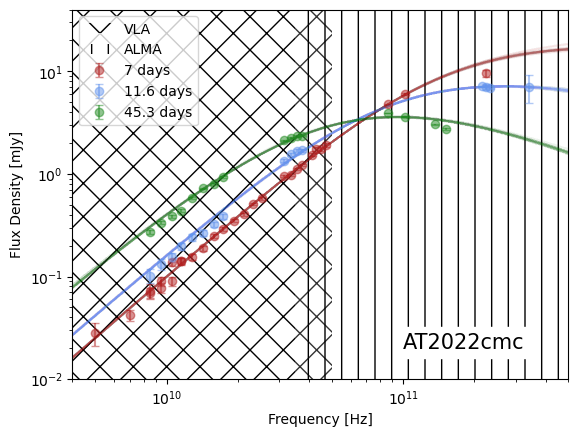

In [10]:
import syncfit

centervals = [7, 11.6, 45.3]
tols = [1, 0.5, 5]
theta_inits = [3, 1, 10, 11]
n = 100
burnin = n//2
model = syncfit.models.B1B2
nkeep = 100
cols = ['firebrick', 'cornflowerblue', 'forestgreen']

fig, ax = plt.subplots()

for val, tol, c in zip(centervals, tols, cols):

    ds = cmc[np.isclose(cmc.t, val, atol=tol)]
    ds = ds[ds.Frequency > 3]
    
    lines = ax.errorbar(1e9*ds.Frequency, ds.FluxDensity, fmt='o', yerr=ds.FluxDensityErr, 
                label=f'{val} days', alpha=0.5, capsize=3, color=c)
    
    
    # with mm data
    sampler = syncfit.do_emcee(theta_inits, ds.Frequency.astype(float), ds.FluxDensity*1e3, 
                                ds.FluxDensityErr*1e3, plot=False, niter=n, model=model)
    out, log_prob = syncfit.analysis.extract_output(sampler)
    nus = np.arange(1e8,5e12,1e7)  
    sed = model.SED
    best = out[np.argsort(log_prob)[-nkeep:]]
    for o in best:
        res = sed(nus, *o)
        ax.plot(nus, res, alpha=0.01, linestyle='-', color=lines[-1][0].get_color())
    
ax.set_ylabel(r'Flux Density [mJy]')
ax.set_xlabel('Frequency [Hz]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.text(1e11, 2e-2, 'AT2022cmc', fontsize=15, backgroundcolor='w')
ax.set_ylim(1e-2, 4e1)
ax.set_xlim(4e9, 5e11)

ax.fill_between(VLA_nus*1e9, [1e-50]*len(VLA_nus), [1000]*len(VLA_nus), label='VLA', alpha=0.2, facecolor='w', hatch="x")
ax.fill_between(ALMA_nus*1e9, [1e-50]*len(ALMA_nus), [1000]*len(ALMA_nus), label='ALMA', alpha=0.2, facecolor="w", hatch="|",)

ax.legend()

fig.savefig('2022cmc-sed-plot.png', transparent=False, bbox_inches='tight')

# AT2019dsg

In [8]:
class CustomB5B3(syncfit.models.B5B3):
    
    # We just need to update the smoothing parameters here!
    
    def SED2(nu, p, log_F_nu, log_nu_a, log_nu_c):
        b1 = 2
        b2 = 5/2
        b3 = (1-p)/2
        b4 = -p/2

        s1 = 3.63*p-1.6
        s2 = 1.25-0.18*p
        s3 = 10

        F_nu = 10**log_F_nu
        nu_m = 0.1*1e9
        nu_a = 10**log_nu_a
        nu_c = 10**log_nu_c


        term1 = ( (nu/nu_m)**(b1) * np.exp(-s1*(nu/nu_m)**(2/3)) + (nu/nu_m)**(b2))
        term2 = ( 1 + (nu/nu_a)**(s2*(b2-b3)) )**(-1/s2)
        term3 = ( 1 + (nu/nu_c)**(s3*(b3-b4)) )**(-1/s3)
        
        return F_nu * term1 * term2 * term3

    def SED(nu, p, log_F_nu, log_nu_a, log_nu_c):
        b1 = 5/2
        b2 = (1-p)/2
        b3 = -p/2

        s12 = 1.25-0.18*p
        s23 = 10 #1.15-0.06*p

        F_nu = 10**log_F_nu
        nu_c = 10**log_nu_c
        nu_a = 10**log_nu_a

        term1 = ((nu/nu_a)**(-s12*b1) + (nu/nu_a)**(-s12*b2))**(-1/s12)
        term2 = (1 + (nu/nu_c)**(s23*(b2-b3)))**(-1/s23)

        return F_nu * term1 * term2
    
    def lnprior(theta, p=None, **kwargs):
        ''' Priors: '''
        if p is None:
            p, log_F_nu, log_nu_a, log_nu_c = theta
        else:
            log_F_nu, log_nu_a, log_nu_c = theta

        if 2 < p < 4 and -1 < log_F_nu < 1 and 9 < log_nu_a < 10.35 and 10.35 < log_nu_c < 10.5:
            return 0.0

        else:
            return -np.inf
    
class CustomB5(syncfit.models.B5):
        
    def lnprior(theta, p=None, **kwargs):
        ''' Priors: '''
        if p is None:
            p, log_F_nu, log_nu_a = theta
        else:
            log_F_nu, log_nu_a = theta

        if 2 < p < 4 and -1 < log_F_nu < 1 and 9 < log_nu_a < 11:
            return 0.0

        else:
            return -np.inf


In [9]:
ds = dsg[np.isclose(dsg.t, 83, atol=2)]
import syncfit

In [10]:
10**10.4 / 1e9

25.11886431509582

  0%|                                                                                                                                                                                      | 0/500 [00:00<?, ?it/s]

  2%|███▏                                                                                                                                                                          | 9/500 [00:00<00:05, 87.18it/s]

  4%|██████▌                                                                                                                                                                      | 19/500 [00:00<00:05, 92.21it/s]

  6%|██████████▍                                                                                                                                                                  | 30/500 [00:00<00:04, 96.13it/s]

  8%|██████████████▏                                                                                                                                                              | 41/500 [00:00<00:04, 98.88it/s]

 10%|█████████████████▋                                                                                                                                                           | 51/500 [00:00<00:04, 98.83it/s]

 12%|█████████████████████                                                                                                                                                        | 61/500 [00:00<00:04, 96.85it/s]

 14%|████████████████████████▌                                                                                                                                                    | 71/500 [00:00<00:04, 95.21it/s]

 16%|████████████████████████████                                                                                                                                                 | 81/500 [00:00<00:04, 94.68it/s]

 18%|███████████████████████████████▍                                                                                                                                             | 91/500 [00:00<00:04, 93.73it/s]

 20%|██████████████████████████████████▋                                                                                                                                         | 101/500 [00:01<00:04, 94.26it/s]

 22%|██████████████████████████████████████▏                                                                                                                                     | 111/500 [00:01<00:04, 95.02it/s]

 24%|█████████████████████████████████████████▌                                                                                                                                  | 121/500 [00:01<00:03, 95.32it/s]

 26%|█████████████████████████████████████████████                                                                                                                               | 131/500 [00:01<00:03, 95.53it/s]

 28%|████████████████████████████████████████████████▌                                                                                                                           | 141/500 [00:01<00:03, 94.13it/s]

 30%|███████████████████████████████████████████████████▉                                                                                                                        | 151/500 [00:01<00:03, 92.51it/s]

 32%|███████████████████████████████████████████████████████▍                                                                                                                    | 161/500 [00:01<00:03, 91.70it/s]

 34%|██████████████████████████████████████████████████████████▊                                                                                                                 | 171/500 [00:01<00:03, 91.02it/s]

 36%|██████████████████████████████████████████████████████████████▎                                                                                                             | 181/500 [00:01<00:03, 91.17it/s]

 38%|█████████████████████████████████████████████████████████████████▋                                                                                                          | 191/500 [00:02<00:03, 90.59it/s]

 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                      | 201/500 [00:02<00:03, 90.73it/s]

 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                   | 211/500 [00:02<00:03, 89.49it/s]

 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 220/500 [00:02<00:03, 89.12it/s]

 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 230/500 [00:02<00:03, 89.99it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 240/500 [00:02<00:02, 91.15it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 250/500 [00:02<00:02, 92.06it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 260/500 [00:02<00:02, 90.86it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 270/500 [00:02<00:02, 90.68it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 280/500 [00:03<00:02, 90.42it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 290/500 [00:03<00:02, 89.27it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 299/500 [00:03<00:02, 87.99it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 308/500 [00:03<00:02, 88.07it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 318/500 [00:03<00:02, 89.49it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 328/500 [00:03<00:01, 90.07it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 338/500 [00:03<00:01, 90.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 348/500 [00:03<00:01, 91.70it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 358/500 [00:03<00:01, 91.98it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 368/500 [00:03<00:01, 92.66it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 378/500 [00:04<00:01, 93.35it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 388/500 [00:04<00:01, 94.15it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 398/500 [00:04<00:01, 94.14it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 408/500 [00:04<00:00, 92.71it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 418/500 [00:04<00:00, 91.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 428/500 [00:04<00:00, 91.15it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 438/500 [00:04<00:00, 91.00it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 448/500 [00:04<00:00, 91.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 458/500 [00:04<00:00, 92.52it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 468/500 [00:05<00:00, 90.67it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 478/500 [00:05<00:00, 90.35it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 488/500 [00:05<00:00, 90.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 498/500 [00:05<00:00, 89.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 91.89it/s]

Best fit values for day:  None
\mathrm{log F_v} = 2.00e-01_{-0.010}^{0.006}
\mathrm{log nu_a} = 9.92e+00_{-0.009}^{0.012}
\mathrm{log nu_c} = 1.04e+01_{-0.011}^{0.033}


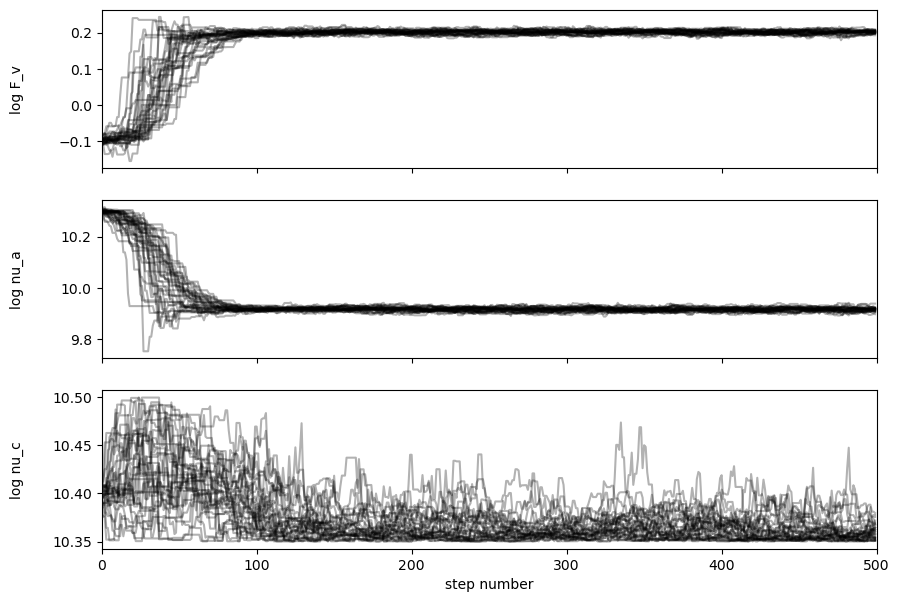

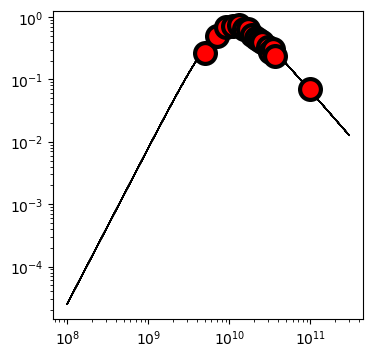

In [11]:
# try to fit the data
theta_inits = [-0.1,10.3,10.4]
n = 500
model = CustomB5B3 #syncfit.models.B5B3
p = 2.97
# p = syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=1000)[0][0]

F_uJy = ds.FluxDensity*1e3
F_err_uJy = ds.FluxDensityErr*1e3

sampler = syncfit.do_emcee(theta_inits, ds.Frequency, F_uJy, F_err_uJy, 
                                plot=True, niter=n, model=model, nwalkers=32, fix_p=p)

out, log_prob = syncfit.analysis.extract_output(sampler)

  0%|                                                                                                                                                                                      | 0/500 [00:00<?, ?it/s]

  2%|████▏                                                                                                                                                                       | 12/500 [00:00<00:04, 116.45it/s]

  5%|████████▎                                                                                                                                                                   | 24/500 [00:00<00:04, 116.37it/s]

  7%|████████████▍                                                                                                                                                               | 36/500 [00:00<00:03, 116.06it/s]

 10%|████████████████▌                                                                                                                                                           | 48/500 [00:00<00:03, 115.07it/s]

 12%|████████████████████▋                                                                                                                                                       | 60/500 [00:00<00:03, 115.11it/s]

 14%|████████████████████████▊                                                                                                                                                   | 72/500 [00:00<00:03, 116.02it/s]

 17%|████████████████████████████▉                                                                                                                                               | 84/500 [00:00<00:03, 116.26it/s]

 19%|█████████████████████████████████                                                                                                                                           | 96/500 [00:00<00:03, 116.56it/s]

 22%|████████████████████████████████████▉                                                                                                                                      | 108/500 [00:00<00:03, 116.76it/s]

 24%|█████████████████████████████████████████                                                                                                                                  | 120/500 [00:01<00:03, 117.08it/s]

 26%|█████████████████████████████████████████████▏                                                                                                                             | 132/500 [00:01<00:03, 117.37it/s]

 29%|█████████████████████████████████████████████████▏                                                                                                                         | 144/500 [00:01<00:03, 117.06it/s]

 31%|█████████████████████████████████████████████████████▎                                                                                                                     | 156/500 [00:01<00:02, 116.84it/s]

 34%|█████████████████████████████████████████████████████████▍                                                                                                                 | 168/500 [00:01<00:02, 116.91it/s]

 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 180/500 [00:01<00:02, 116.48it/s]

 38%|█████████████████████████████████████████████████████████████████▋                                                                                                         | 192/500 [00:01<00:02, 116.77it/s]

 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                     | 204/500 [00:01<00:02, 116.67it/s]

 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                 | 216/500 [00:01<00:02, 116.70it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                             | 228/500 [00:01<00:02, 116.86it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                         | 240/500 [00:02<00:02, 117.00it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 252/500 [00:02<00:02, 116.50it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 264/500 [00:02<00:02, 115.55it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 276/500 [00:02<00:01, 114.34it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 288/500 [00:02<00:01, 113.50it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 300/500 [00:02<00:01, 112.90it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 312/500 [00:02<00:01, 112.42it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 324/500 [00:02<00:01, 111.99it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 336/500 [00:02<00:01, 111.99it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 348/500 [00:03<00:01, 111.79it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 360/500 [00:03<00:01, 111.74it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 372/500 [00:03<00:01, 111.15it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 384/500 [00:03<00:01, 110.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 396/500 [00:03<00:00, 110.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 408/500 [00:03<00:00, 110.88it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 420/500 [00:03<00:00, 111.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 432/500 [00:03<00:00, 111.16it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 444/500 [00:03<00:00, 111.30it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 456/500 [00:03<00:00, 111.46it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 468/500 [00:04<00:00, 111.39it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 480/500 [00:04<00:00, 111.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 492/500 [00:04<00:00, 111.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 113.92it/s]

Best fit values for day:  None
\mathrm{log F_v} = 1.88e-01_{-0.008}^{0.006}
\mathrm{log nu_a} = 9.90e+00_{-0.008}^{0.011}


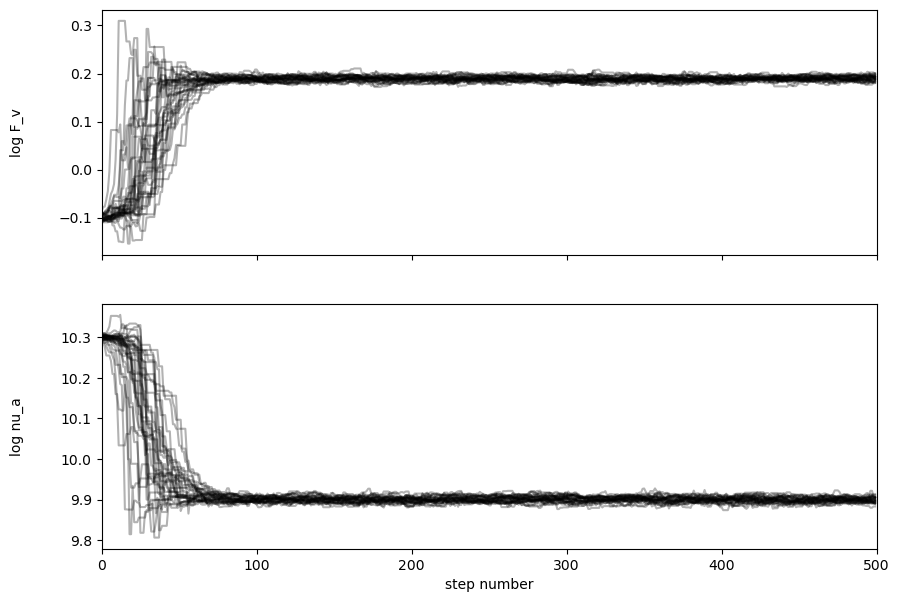

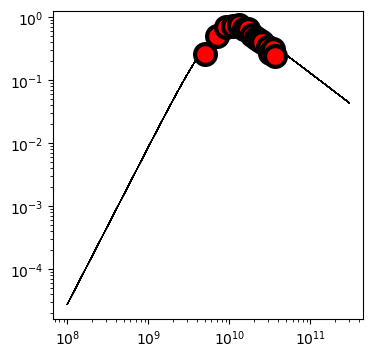

In [12]:
# without mm fit

# try to fit the data
theta_inits = [-0.1,10.3]
n = 500
model = CustomB5
p = 2.97 #syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=n//2)[0][0]

F_uJy = ds.FluxDensity[ds.Frequency < 8e10/1e9]*1e3
F_err_uJy = ds.FluxDensityErr[ds.Frequency < 8e10/1e9]*1e3

sampler_nomm = syncfit.do_emcee(theta_inits, ds.Frequency[ds.Frequency < 8e10/1e9], F_uJy, F_err_uJy, 
                                plot=True, niter=n, model=model, nwalkers=32, fix_p=p)

out_nomm, log_prob_nomm = syncfit.analysis.extract_output(sampler_nomm)

(1000000000.0, 40000000000.0)

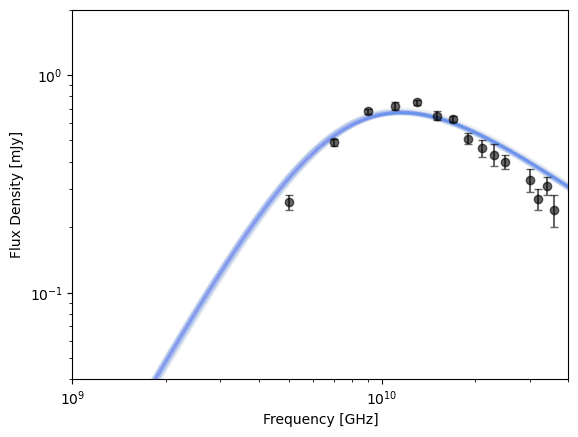

In [16]:
# plot up the data
fig, ax = plt.subplots()
nkeep = 200
nus = np.arange(1e8,3e11,1e7)
best = out_nomm[-nkeep:]#[np.argsort(log_prob_nomm)[-nkeep:]]
nus = np.arange(1e8,3e11,1e7)
for o in best:
    res = CustomB5.SED(nus, p, *o) #
    ax.plot(nus, res, alpha=0.01, linestyle='-', color='cornflowerblue')

F_mJy = ds.FluxDensity[ds.Frequency < 8e10/1e9]
F_err_mJy = ds.FluxDensityErr[ds.Frequency < 8e10/1e9]
ax.errorbar(ds.Frequency[ds.Frequency < 8e10/1e9]*1e9, F_mJy, yerr=F_err_mJy, fmt='o', alpha=0.6, color='k', capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Flux Density [mJy]')
ax.set_xlabel('Frequency [GHz]')

ax.set_ylim(4e-2, 2e0)
ax.set_xlim(1e9, 4e10)

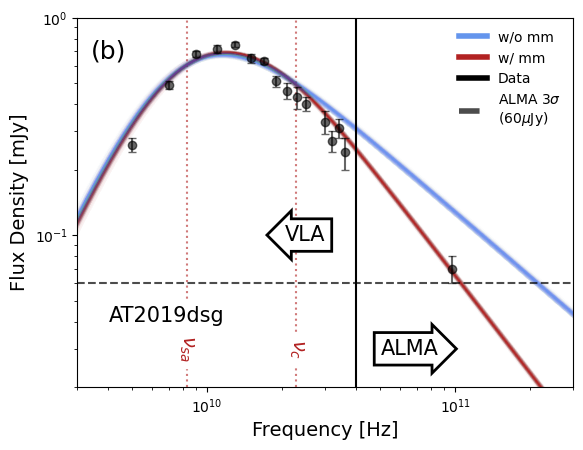

In [16]:
# plot up the data
fig, ax = plt.subplots()
nkeep = 200
nus = np.arange(1e8,3e11,1e7)
best = out[-nkeep:]#[np.argsort(log_prob)[-nkeep:]] #  
for o in best:
    res = CustomB5B3.SED(nus, p, *o)
    ax.plot(nus, res, alpha=0.01, linestyle='-', color='firebrick')

# # plot nu_c vertical line
nu_c = 10**syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=n//2)[0][-1]
ax.axvline(nu_c, linestyle=':', color='firebrick', alpha=0.6) # pulled from the printout above
ax.text(nu_c, 3e-2, r'$\nu_c$', fontsize=14, ha='center', va='center',
        rotation=-90, alpha=1, backgroundcolor='w', color='firebrick')

# # plot nu_c vertical line
nu_a = 10**syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a', 'log nu_c'], discard=n//2)[0][-2]
ax.axvline(nu_a, linestyle=':', alpha=0.6, color='firebrick') # pulled from the printout above
ax.text(nu_a, 3e-2, r'$\nu_{sa}$', fontsize=14, ha='center', va='center',
        rotation=-90, alpha=1, backgroundcolor='w', color='firebrick')

best = out_nomm[-nkeep:]#[np.argsort(log_prob_nomm)[-nkeep:]]
nus = np.arange(1e8,3e11,1e7)
for o in best:
    res = CustomB5.SED(nus, p, *o) #
    ax.plot(nus, res, alpha=0.01, linestyle='-', color='cornflowerblue')

#nu_a = 10**syncfit.analysis.get_bounds(sampler_nomm, labels=['p', 'log F_v', 'log nu_a'], discard=n//2)[0][-1]
#ax.axvline(nu_a, linestyle=':', alpha=0.6, color='cornflowerblue') # pulled from the printout above
#ax.text(nu_a, 3e-2, r'$\nu_{sa}$', fontsize=14, ha='center', va='center',
#        rotation=-90, alpha=1, backgroundcolor='w', color='cornflowerblue')
    
ax.set_ylim(2e-2, 1e0)
ax.set_xlim(3e9, 3e11)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

custom_lines = [Line2D([0], [0], color='cornflowerblue', lw=4),
                Line2D([0], [0], color='firebrick', lw=4),
                Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='k', alpha=0.7, linestyle='--', lw=4),
                Patch(facecolor='k', alpha=0.2, hatch='x'),
                Patch(facecolor='k', alpha=0.2, hatch='|')
               ]

labels = ['w/o mm', 'w/ mm', 'Data', 'ALMA 3$\sigma$ \n(60$\mu$Jy)']

ax.errorbar(ds.Frequency*1e9, ds.FluxDensity, yerr=ds.FluxDensityErr, fmt='o', alpha=0.6, color='k', capsize=3)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Flux Density [mJy]', fontsize=14)
ax.set_xlabel('Frequency [Hz]', fontsize=14)

# ax.fill_between(VLA_nus*1e9, [1e-50]*len(VLA_nus), [1000]*len(VLA_nus), label='VLA', alpha=0.2, facecolor='w', hatch="x")
# ax.fill_between(ALMA_nus*1e9, [1e-50]*len(ALMA_nus), [1000]*len(ALMA_nus), label='ALMA', alpha=0.2, facecolor="w", hatch="|",)

ax.axvline(40e9, color='k', linestyle='-')
ax.text(30e9, 1e-1, "VLA",
        ha="right", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="larrow,pad=0.3", lw=2, fc='w', ec='k')
       )
ax.text(50e9, 3e-2, "ALMA",
        ha="left", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="rarrow,pad=0.3", lw=2, fc='w', ec='k')
       )

ax.text(4e9, 7e-1, '(b)', ha='center', va='center', rotation=0, size=18)

ax.axhline(60e-3, linestyle='--', color='k', alpha=0.7, label='ALMA 3$\sigma$ \n(60$\mu$Jy)')

ax.legend(custom_lines, labels, frameon=False, loc='upper right')

ax.text(4e9, 4e-2, 'AT2019dsg', fontsize=15, backgroundcolor='w')

fig.savefig('2019dsg-sed-plot.png', transparent=False, bbox_inches='tight')

# AT2019qiz

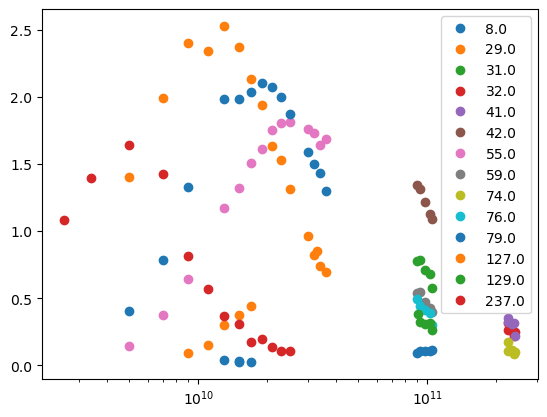

In [7]:
data = pd.DataFrame(np.loadtxt('AT2019qiz_sed.txt'), columns=['t', 'Frequency', 'FluxDensity', 'FluxDensityErr'])
data['FluxDensity'] = data.FluxDensity*1e-3
data['FluxDensityErr'] = data.FluxDensityErr*1e-3


fig, ax = plt.subplots()

# plot the data
for d,grp in data.groupby('t'):
    ax.errorbar(grp.Frequency*1e9, grp.FluxDensity, marker='o', linestyle='none', label=f'{d}')
    
ax.set_xscale('log')
ax.legend()

In [8]:
class CustomB5_qiz(syncfit.models.B5):
    
    def lnprior(theta, p=None, **kwargs):
        ''' Priors: '''
        if p is None:
            p, log_F_nu, log_nu_a = theta
        else:
            log_F_nu, log_nu_a = theta

        if 3 < p < 5 and -4 < log_F_nu < 2 and 6 < log_nu_a < 11:
            return 0.0

        else:
            return -np.inf

  0%|                                                                                                                                                                                     | 0/1000 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                                            | 4/1000 [00:00<00:25, 39.26it/s]

  1%|█▍                                                                                                                                                                           | 8/1000 [00:00<00:25, 39.28it/s]

  1%|██                                                                                                                                                                          | 12/1000 [00:00<00:25, 39.25it/s]

  2%|██▊                                                                                                                                                                         | 16/1000 [00:00<00:25, 39.33it/s]

  2%|███▌                                                                                                                                                                        | 21/1000 [00:00<00:24, 40.66it/s]

  3%|████▍                                                                                                                                                                       | 26/1000 [00:00<00:22, 42.56it/s]

  3%|█████▎                                                                                                                                                                      | 31/1000 [00:00<00:21, 44.13it/s]

  4%|██████▏                                                                                                                                                                     | 36/1000 [00:00<00:21, 45.31it/s]

  4%|███████                                                                                                                                                                     | 41/1000 [00:00<00:20, 46.11it/s]

  5%|███████▉                                                                                                                                                                    | 46/1000 [00:01<00:20, 46.56it/s]

  5%|████████▊                                                                                                                                                                   | 51/1000 [00:01<00:20, 47.06it/s]

  6%|█████████▋                                                                                                                                                                  | 56/1000 [00:01<00:19, 47.51it/s]

  6%|██████████▍                                                                                                                                                                 | 61/1000 [00:01<00:19, 47.87it/s]

  7%|███████████▎                                                                                                                                                                | 66/1000 [00:01<00:19, 48.38it/s]

  7%|████████████▏                                                                                                                                                               | 71/1000 [00:01<00:19, 48.01it/s]

  8%|█████████████                                                                                                                                                               | 76/1000 [00:01<00:19, 47.73it/s]

  8%|█████████████▉                                                                                                                                                              | 81/1000 [00:01<00:19, 48.21it/s]

  9%|██████████████▊                                                                                                                                                             | 86/1000 [00:01<00:19, 47.98it/s]

  9%|███████████████▋                                                                                                                                                            | 91/1000 [00:01<00:18, 48.43it/s]

 10%|████████████████▌                                                                                                                                                           | 96/1000 [00:02<00:18, 48.08it/s]

 10%|█████████████████▎                                                                                                                                                         | 101/1000 [00:02<00:18, 47.74it/s]

 11%|██████████████████▏                                                                                                                                                        | 106/1000 [00:02<00:18, 47.79it/s]

 11%|██████████████████▉                                                                                                                                                        | 111/1000 [00:02<00:18, 47.92it/s]

 12%|███████████████████▊                                                                                                                                                       | 116/1000 [00:02<00:18, 47.81it/s]

 12%|████████████████████▋                                                                                                                                                      | 121/1000 [00:02<00:18, 47.73it/s]

 13%|█████████████████████▌                                                                                                                                                     | 126/1000 [00:02<00:18, 47.68it/s]

 13%|██████████████████████▍                                                                                                                                                    | 131/1000 [00:02<00:18, 47.01it/s]

 14%|███████████████████████▎                                                                                                                                                   | 136/1000 [00:02<00:18, 46.81it/s]

 14%|████████████████████████                                                                                                                                                   | 141/1000 [00:03<00:18, 47.30it/s]

 15%|████████████████████████▉                                                                                                                                                  | 146/1000 [00:03<00:18, 46.73it/s]

 15%|█████████████████████████▊                                                                                                                                                 | 151/1000 [00:03<00:18, 46.39it/s]

 16%|██████████████████████████▋                                                                                                                                                | 156/1000 [00:03<00:18, 45.93it/s]

 16%|███████████████████████████▌                                                                                                                                               | 161/1000 [00:03<00:18, 45.27it/s]

 17%|████████████████████████████▍                                                                                                                                              | 166/1000 [00:03<00:18, 45.10it/s]

 17%|█████████████████████████████▏                                                                                                                                             | 171/1000 [00:03<00:18, 45.23it/s]

 18%|██████████████████████████████                                                                                                                                             | 176/1000 [00:03<00:18, 45.42it/s]

 18%|██████████████████████████████▉                                                                                                                                            | 181/1000 [00:03<00:18, 45.28it/s]

 19%|███████████████████████████████▊                                                                                                                                           | 186/1000 [00:04<00:18, 43.88it/s]

 19%|████████████████████████████████▋                                                                                                                                          | 191/1000 [00:04<00:18, 43.16it/s]

 20%|█████████████████████████████████▌                                                                                                                                         | 196/1000 [00:04<00:19, 41.31it/s]

 20%|██████████████████████████████████▎                                                                                                                                        | 201/1000 [00:04<00:19, 41.13it/s]

 21%|███████████████████████████████████▏                                                                                                                                       | 206/1000 [00:04<00:19, 41.53it/s]

 21%|████████████████████████████████████                                                                                                                                       | 211/1000 [00:04<00:19, 40.45it/s]

 22%|████████████████████████████████████▉                                                                                                                                      | 216/1000 [00:04<00:19, 40.92it/s]

 22%|█████████████████████████████████████▊                                                                                                                                     | 221/1000 [00:04<00:18, 41.53it/s]

 23%|██████████████████████████████████████▋                                                                                                                                    | 226/1000 [00:05<00:18, 41.49it/s]

 23%|███████████████████████████████████████▌                                                                                                                                   | 231/1000 [00:05<00:18, 41.68it/s]

 24%|████████████████████████████████████████▎                                                                                                                                  | 236/1000 [00:05<00:18, 41.79it/s]

 24%|█████████████████████████████████████████▏                                                                                                                                 | 241/1000 [00:05<00:18, 41.53it/s]

 25%|██████████████████████████████████████████                                                                                                                                 | 246/1000 [00:05<00:17, 42.07it/s]

 25%|██████████████████████████████████████████▉                                                                                                                                | 251/1000 [00:05<00:17, 41.98it/s]

 26%|███████████████████████████████████████████▊                                                                                                                               | 256/1000 [00:05<00:17, 41.84it/s]

 26%|████████████████████████████████████████████▋                                                                                                                              | 261/1000 [00:05<00:17, 41.70it/s]

 27%|█████████████████████████████████████████████▍                                                                                                                             | 266/1000 [00:05<00:17, 42.16it/s]

 27%|██████████████████████████████████████████████▎                                                                                                                            | 271/1000 [00:06<00:17, 42.02it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                           | 276/1000 [00:06<00:17, 41.74it/s]

 28%|████████████████████████████████████████████████                                                                                                                           | 281/1000 [00:06<00:17, 42.05it/s]

 29%|████████████████████████████████████████████████▉                                                                                                                          | 286/1000 [00:06<00:16, 42.53it/s]

 29%|█████████████████████████████████████████████████▊                                                                                                                         | 291/1000 [00:06<00:16, 42.95it/s]

 30%|██████████████████████████████████████████████████▌                                                                                                                        | 296/1000 [00:06<00:16, 42.68it/s]

 30%|███████████████████████████████████████████████████▍                                                                                                                       | 301/1000 [00:06<00:16, 42.65it/s]

 31%|████████████████████████████████████████████████████▎                                                                                                                      | 306/1000 [00:06<00:16, 42.86it/s]

 31%|█████████████████████████████████████████████████████▏                                                                                                                     | 311/1000 [00:07<00:16, 42.53it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                     | 316/1000 [00:07<00:16, 42.47it/s]

 32%|██████████████████████████████████████████████████████▉                                                                                                                    | 321/1000 [00:07<00:15, 42.75it/s]

 33%|███████████████████████████████████████████████████████▋                                                                                                                   | 326/1000 [00:07<00:15, 43.13it/s]

 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 331/1000 [00:07<00:15, 43.00it/s]

 34%|█████████████████████████████████████████████████████████▍                                                                                                                 | 336/1000 [00:07<00:15, 43.00it/s]

 34%|██████████████████████████████████████████████████████████▎                                                                                                                | 341/1000 [00:07<00:15, 42.73it/s]

 35%|███████████████████████████████████████████████████████████▏                                                                                                               | 346/1000 [00:07<00:15, 42.76it/s]

 35%|████████████████████████████████████████████████████████████                                                                                                               | 351/1000 [00:07<00:15, 42.39it/s]

 36%|████████████████████████████████████████████████████████████▉                                                                                                              | 356/1000 [00:08<00:15, 41.43it/s]

 36%|█████████████████████████████████████████████████████████████▋                                                                                                             | 361/1000 [00:08<00:15, 41.27it/s]

 37%|██████████████████████████████████████████████████████████████▌                                                                                                            | 366/1000 [00:08<00:15, 41.78it/s]

 37%|███████████████████████████████████████████████████████████████▍                                                                                                           | 371/1000 [00:08<00:15, 41.49it/s]

 38%|████████████████████████████████████████████████████████████████▎                                                                                                          | 376/1000 [00:08<00:15, 40.72it/s]

 38%|█████████████████████████████████████████████████████████████████▏                                                                                                         | 381/1000 [00:08<00:15, 40.55it/s]

 39%|██████████████████████████████████████████████████████████████████                                                                                                         | 386/1000 [00:08<00:15, 40.76it/s]

 39%|██████████████████████████████████████████████████████████████████▊                                                                                                        | 391/1000 [00:08<00:15, 40.44it/s]

 40%|███████████████████████████████████████████████████████████████████▋                                                                                                       | 396/1000 [00:09<00:14, 40.57it/s]

 40%|████████████████████████████████████████████████████████████████████▌                                                                                                      | 401/1000 [00:09<00:14, 40.40it/s]

 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                     | 406/1000 [00:09<00:14, 40.64it/s]

 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                    | 411/1000 [00:09<00:14, 40.49it/s]

 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                   | 416/1000 [00:09<00:14, 41.01it/s]

 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                   | 421/1000 [00:09<00:14, 41.23it/s]

 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                  | 426/1000 [00:09<00:13, 41.79it/s]

 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                 | 431/1000 [00:09<00:13, 42.02it/s]

 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                                | 436/1000 [00:10<00:13, 41.96it/s]

 44%|███████████████████████████████████████████████████████████████████████████▍                                                                                               | 441/1000 [00:10<00:13, 42.12it/s]

 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                              | 446/1000 [00:10<00:13, 40.50it/s]

 45%|█████████████████████████████████████████████████████████████████████████████                                                                                              | 451/1000 [00:10<00:13, 39.76it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                             | 455/1000 [00:10<00:13, 39.31it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                            | 459/1000 [00:10<00:13, 39.35it/s]

 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                           | 463/1000 [00:10<00:13, 39.26it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                           | 467/1000 [00:10<00:13, 39.21it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 472/1000 [00:10<00:13, 39.62it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 477/1000 [00:11<00:13, 40.03it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 482/1000 [00:11<00:12, 40.30it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 487/1000 [00:11<00:12, 40.21it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 492/1000 [00:11<00:12, 40.24it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 497/1000 [00:11<00:12, 40.43it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 502/1000 [00:11<00:12, 40.69it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 507/1000 [00:11<00:12, 40.92it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 512/1000 [00:11<00:11, 41.08it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 517/1000 [00:12<00:11, 40.94it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 522/1000 [00:12<00:11, 40.75it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 527/1000 [00:12<00:11, 40.82it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 532/1000 [00:12<00:11, 41.13it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 537/1000 [00:12<00:11, 41.18it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 542/1000 [00:12<00:11, 40.69it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 547/1000 [00:12<00:11, 41.04it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 552/1000 [00:12<00:10, 41.09it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 557/1000 [00:13<00:10, 41.32it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 562/1000 [00:13<00:10, 41.34it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/1000 [00:13<00:10, 40.92it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 572/1000 [00:13<00:10, 41.10it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 577/1000 [00:13<00:10, 41.07it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 582/1000 [00:13<00:10, 41.13it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 587/1000 [00:13<00:10, 40.95it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 592/1000 [00:13<00:09, 40.85it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 597/1000 [00:14<00:10, 40.13it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 602/1000 [00:14<00:09, 40.51it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 607/1000 [00:14<00:09, 40.30it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 612/1000 [00:14<00:09, 40.51it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 617/1000 [00:14<00:09, 40.57it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 622/1000 [00:14<00:09, 40.26it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 627/1000 [00:14<00:09, 39.53it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 631/1000 [00:14<00:09, 39.45it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 635/1000 [00:14<00:09, 39.21it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 639/1000 [00:15<00:09, 39.19it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 644/1000 [00:15<00:08, 39.82it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 648/1000 [00:15<00:08, 39.78it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 652/1000 [00:15<00:08, 39.61it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 657/1000 [00:15<00:08, 39.67it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 661/1000 [00:15<00:08, 39.26it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 665/1000 [00:15<00:08, 39.24it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 669/1000 [00:15<00:08, 39.01it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 674/1000 [00:15<00:08, 39.44it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 679/1000 [00:16<00:08, 39.72it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 684/1000 [00:16<00:07, 39.99it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 689/1000 [00:16<00:07, 40.05it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 694/1000 [00:16<00:07, 39.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 698/1000 [00:16<00:07, 39.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 703/1000 [00:16<00:07, 39.77it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 708/1000 [00:16<00:07, 40.08it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 713/1000 [00:16<00:07, 40.29it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 718/1000 [00:17<00:07, 40.22it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 723/1000 [00:17<00:07, 39.48it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 728/1000 [00:17<00:06, 39.80it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 732/1000 [00:17<00:06, 39.52it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 736/1000 [00:17<00:06, 39.60it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 741/1000 [00:17<00:06, 39.89it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 746/1000 [00:17<00:06, 40.15it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 751/1000 [00:17<00:06, 40.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 756/1000 [00:18<00:06, 40.41it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 761/1000 [00:18<00:05, 40.24it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 766/1000 [00:18<00:05, 40.50it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 771/1000 [00:18<00:05, 40.42it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 776/1000 [00:18<00:05, 40.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 781/1000 [00:18<00:05, 40.72it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 786/1000 [00:18<00:05, 40.71it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 791/1000 [00:18<00:05, 40.66it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 796/1000 [00:19<00:05, 40.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 801/1000 [00:19<00:05, 39.63it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 805/1000 [00:19<00:04, 39.45it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 809/1000 [00:19<00:04, 39.50it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 814/1000 [00:19<00:04, 39.85it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 818/1000 [00:19<00:04, 39.42it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 822/1000 [00:19<00:04, 38.75it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 826/1000 [00:19<00:04, 38.67it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 830/1000 [00:19<00:04, 38.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 834/1000 [00:19<00:04, 38.93it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 839/1000 [00:20<00:04, 39.20it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 844/1000 [00:20<00:03, 39.69it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 849/1000 [00:20<00:03, 39.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 853/1000 [00:20<00:03, 39.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 857/1000 [00:20<00:03, 39.67it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 861/1000 [00:20<00:03, 39.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 865/1000 [00:20<00:03, 39.47it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 869/1000 [00:20<00:03, 39.61it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 874/1000 [00:20<00:03, 40.00it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 879/1000 [00:21<00:03, 40.25it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 884/1000 [00:21<00:02, 40.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 889/1000 [00:21<00:02, 40.77it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 894/1000 [00:21<00:02, 40.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 899/1000 [00:21<00:02, 39.28it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 903/1000 [00:21<00:02, 39.25it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 907/1000 [00:21<00:02, 39.42it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 912/1000 [00:21<00:02, 39.63it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 916/1000 [00:22<00:02, 39.62it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 920/1000 [00:22<00:02, 39.42it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 924/1000 [00:22<00:01, 39.17it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 928/1000 [00:22<00:01, 39.36it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 933/1000 [00:22<00:01, 39.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 938/1000 [00:22<00:01, 39.92it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 942/1000 [00:22<00:01, 39.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 946/1000 [00:22<00:01, 39.19it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 950/1000 [00:22<00:01, 39.17it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 954/1000 [00:23<00:01, 38.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 958/1000 [00:23<00:01, 39.07it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 962/1000 [00:23<00:00, 38.41it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 966/1000 [00:23<00:00, 37.97it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 970/1000 [00:23<00:00, 38.13it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [00:23<00:00, 38.28it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 978/1000 [00:23<00:00, 38.37it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [00:23<00:00, 38.83it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 986/1000 [00:23<00:00, 38.92it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [00:23<00:00, 39.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [00:24<00:00, 39.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [00:24<00:00, 39.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.33it/s]

  0%|                                                                                                                                                                                     | 0/1000 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                                            | 4/1000 [00:00<00:25, 39.59it/s]

  1%|█▍                                                                                                                                                                           | 8/1000 [00:00<00:25, 39.32it/s]

  1%|██                                                                                                                                                                          | 12/1000 [00:00<00:25, 39.11it/s]

  2%|██▊                                                                                                                                                                         | 16/1000 [00:00<00:25, 39.10it/s]

  2%|███▍                                                                                                                                                                        | 20/1000 [00:00<00:25, 39.02it/s]

  2%|████▎                                                                                                                                                                       | 25/1000 [00:00<00:24, 39.48it/s]

  3%|█████▏                                                                                                                                                                      | 30/1000 [00:00<00:24, 40.00it/s]

  4%|██████                                                                                                                                                                      | 35/1000 [00:00<00:23, 40.68it/s]

  4%|██████▉                                                                                                                                                                     | 40/1000 [00:00<00:23, 41.00it/s]

  4%|███████▋                                                                                                                                                                    | 45/1000 [00:01<00:23, 41.16it/s]

  5%|████████▌                                                                                                                                                                   | 50/1000 [00:01<00:23, 41.25it/s]

  6%|█████████▍                                                                                                                                                                  | 55/1000 [00:01<00:24, 39.20it/s]

  6%|██████████▏                                                                                                                                                                 | 59/1000 [00:01<00:24, 38.93it/s]

  6%|███████████                                                                                                                                                                 | 64/1000 [00:01<00:23, 39.71it/s]

  7%|███████████▊                                                                                                                                                                | 69/1000 [00:01<00:23, 40.03it/s]

  7%|████████████▋                                                                                                                                                               | 74/1000 [00:01<00:23, 39.00it/s]

  8%|█████████████▌                                                                                                                                                              | 79/1000 [00:01<00:23, 39.48it/s]

  8%|██████████████▍                                                                                                                                                             | 84/1000 [00:02<00:23, 39.73it/s]

  9%|███████████████▏                                                                                                                                                            | 88/1000 [00:02<00:23, 39.46it/s]

  9%|███████████████▊                                                                                                                                                            | 92/1000 [00:02<00:23, 39.40it/s]

 10%|████████████████▌                                                                                                                                                           | 96/1000 [00:02<00:23, 39.22it/s]

 10%|█████████████████▎                                                                                                                                                         | 101/1000 [00:02<00:22, 39.72it/s]

 10%|█████████████████▉                                                                                                                                                         | 105/1000 [00:02<00:22, 39.79it/s]

 11%|██████████████████▋                                                                                                                                                        | 109/1000 [00:02<00:22, 39.53it/s]

 11%|███████████████████▎                                                                                                                                                       | 113/1000 [00:02<00:22, 39.59it/s]

 12%|████████████████████                                                                                                                                                       | 117/1000 [00:02<00:22, 39.50it/s]

 12%|████████████████████▋                                                                                                                                                      | 121/1000 [00:03<00:22, 39.32it/s]

 12%|█████████████████████▍                                                                                                                                                     | 125/1000 [00:03<00:22, 38.99it/s]

 13%|██████████████████████                                                                                                                                                     | 129/1000 [00:03<00:22, 38.80it/s]

 13%|██████████████████████▋                                                                                                                                                    | 133/1000 [00:03<00:22, 38.60it/s]

 14%|███████████████████████▍                                                                                                                                                   | 137/1000 [00:03<00:22, 38.50it/s]

 14%|████████████████████████                                                                                                                                                   | 141/1000 [00:03<00:22, 38.11it/s]

 14%|████████████████████████▊                                                                                                                                                  | 145/1000 [00:03<00:22, 38.29it/s]

 15%|█████████████████████████▋                                                                                                                                                 | 150/1000 [00:03<00:21, 38.94it/s]

 15%|██████████████████████████▎                                                                                                                                                | 154/1000 [00:03<00:22, 38.34it/s]

 16%|███████████████████████████▏                                                                                                                                               | 159/1000 [00:04<00:21, 38.98it/s]

 16%|███████████████████████████▊                                                                                                                                               | 163/1000 [00:04<00:21, 38.69it/s]

 17%|████████████████████████████▌                                                                                                                                              | 167/1000 [00:04<00:21, 38.81it/s]

 17%|█████████████████████████████▏                                                                                                                                             | 171/1000 [00:04<00:21, 39.07it/s]

 18%|█████████████████████████████▉                                                                                                                                             | 175/1000 [00:04<00:21, 39.26it/s]

 18%|██████████████████████████████▌                                                                                                                                            | 179/1000 [00:04<00:21, 38.20it/s]

 18%|███████████████████████████████▎                                                                                                                                           | 183/1000 [00:04<00:21, 38.23it/s]

 19%|███████████████████████████████▉                                                                                                                                           | 187/1000 [00:04<00:20, 38.72it/s]

 19%|████████████████████████████████▋                                                                                                                                          | 191/1000 [00:04<00:20, 38.92it/s]

 20%|█████████████████████████████████▎                                                                                                                                         | 195/1000 [00:04<00:20, 39.01it/s]

 20%|██████████████████████████████████                                                                                                                                         | 199/1000 [00:05<00:20, 39.20it/s]

 20%|██████████████████████████████████▋                                                                                                                                        | 203/1000 [00:05<00:20, 39.24it/s]

 21%|███████████████████████████████████▍                                                                                                                                       | 207/1000 [00:05<00:20, 39.16it/s]

 21%|████████████████████████████████████                                                                                                                                       | 211/1000 [00:05<00:20, 39.35it/s]

 22%|████████████████████████████████████▊                                                                                                                                      | 215/1000 [00:05<00:19, 39.28it/s]

 22%|█████████████████████████████████████▍                                                                                                                                     | 219/1000 [00:05<00:19, 39.17it/s]

 22%|██████████████████████████████████████▏                                                                                                                                    | 223/1000 [00:05<00:19, 39.09it/s]

 23%|██████████████████████████████████████▊                                                                                                                                    | 227/1000 [00:05<00:19, 38.97it/s]

 23%|███████████████████████████████████████▌                                                                                                                                   | 231/1000 [00:05<00:19, 38.98it/s]

 24%|████████████████████████████████████████▏                                                                                                                                  | 235/1000 [00:05<00:19, 38.97it/s]

 24%|████████████████████████████████████████▊                                                                                                                                  | 239/1000 [00:06<00:19, 38.51it/s]

 24%|█████████████████████████████████████████▌                                                                                                                                 | 243/1000 [00:06<00:19, 38.49it/s]

 25%|██████████████████████████████████████████▏                                                                                                                                | 247/1000 [00:06<00:19, 38.41it/s]

 25%|██████████████████████████████████████████▉                                                                                                                                | 251/1000 [00:06<00:19, 38.51it/s]

 26%|███████████████████████████████████████████▌                                                                                                                               | 255/1000 [00:06<00:19, 38.38it/s]

 26%|████████████████████████████████████████████▎                                                                                                                              | 259/1000 [00:06<00:19, 38.23it/s]

 26%|████████████████████████████████████████████▉                                                                                                                              | 263/1000 [00:06<00:19, 38.73it/s]

 27%|█████████████████████████████████████████████▋                                                                                                                             | 267/1000 [00:06<00:18, 38.65it/s]

 27%|██████████████████████████████████████████████▎                                                                                                                            | 271/1000 [00:06<00:19, 38.10it/s]

 28%|███████████████████████████████████████████████                                                                                                                            | 275/1000 [00:07<00:18, 38.19it/s]

 28%|███████████████████████████████████████████████▋                                                                                                                           | 279/1000 [00:07<00:18, 38.20it/s]

 28%|████████████████████████████████████████████████▍                                                                                                                          | 283/1000 [00:07<00:18, 37.91it/s]

 29%|█████████████████████████████████████████████████                                                                                                                          | 287/1000 [00:07<00:18, 37.98it/s]

 29%|█████████████████████████████████████████████████▊                                                                                                                         | 291/1000 [00:07<00:18, 37.97it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                        | 295/1000 [00:07<00:18, 37.87it/s]

 30%|███████████████████████████████████████████████████▏                                                                                                                       | 299/1000 [00:07<00:18, 37.99it/s]

 30%|███████████████████████████████████████████████████▊                                                                                                                       | 303/1000 [00:07<00:18, 38.06it/s]

 31%|████████████████████████████████████████████████████▍                                                                                                                      | 307/1000 [00:07<00:18, 38.09it/s]

 31%|█████████████████████████████████████████████████████▏                                                                                                                     | 311/1000 [00:07<00:18, 37.70it/s]

 32%|█████████████████████████████████████████████████████▊                                                                                                                     | 315/1000 [00:08<00:18, 37.70it/s]

 32%|██████████████████████████████████████████████████████▌                                                                                                                    | 319/1000 [00:08<00:17, 37.90it/s]

 32%|███████████████████████████████████████████████████████▏                                                                                                                   | 323/1000 [00:08<00:17, 37.67it/s]

 33%|███████████████████████████████████████████████████████▉                                                                                                                   | 327/1000 [00:08<00:17, 37.64it/s]

 33%|████████████████████████████████████████████████████████▌                                                                                                                  | 331/1000 [00:08<00:17, 37.77it/s]

 34%|█████████████████████████████████████████████████████████▎                                                                                                                 | 335/1000 [00:08<00:17, 37.84it/s]

 34%|█████████████████████████████████████████████████████████▉                                                                                                                 | 339/1000 [00:08<00:17, 37.63it/s]

 34%|██████████████████████████████████████████████████████████▋                                                                                                                | 343/1000 [00:08<00:17, 37.73it/s]

 35%|███████████████████████████████████████████████████████████▎                                                                                                               | 347/1000 [00:08<00:17, 37.84it/s]

 35%|████████████████████████████████████████████████████████████                                                                                                               | 351/1000 [00:09<00:17, 37.91it/s]

 36%|████████████████████████████████████████████████████████████▋                                                                                                              | 355/1000 [00:09<00:17, 37.92it/s]

 36%|█████████████████████████████████████████████████████████████▍                                                                                                             | 359/1000 [00:09<00:16, 37.91it/s]

 36%|██████████████████████████████████████████████████████████████                                                                                                             | 363/1000 [00:09<00:16, 37.94it/s]

 37%|██████████████████████████████████████████████████████████████▊                                                                                                            | 367/1000 [00:09<00:16, 38.02it/s]

 37%|███████████████████████████████████████████████████████████████▍                                                                                                           | 371/1000 [00:09<00:16, 38.01it/s]

 38%|████████████████████████████████████████████████████████████████▏                                                                                                          | 375/1000 [00:09<00:16, 38.23it/s]

 38%|████████████████████████████████████████████████████████████████▊                                                                                                          | 379/1000 [00:09<00:16, 38.07it/s]

 38%|█████████████████████████████████████████████████████████████████▍                                                                                                         | 383/1000 [00:09<00:16, 38.23it/s]

 39%|██████████████████████████████████████████████████████████████████▏                                                                                                        | 387/1000 [00:09<00:16, 38.13it/s]

 39%|██████████████████████████████████████████████████████████████████▊                                                                                                        | 391/1000 [00:10<00:15, 38.14it/s]

 40%|███████████████████████████████████████████████████████████████████▌                                                                                                       | 395/1000 [00:10<00:15, 38.09it/s]

 40%|████████████████████████████████████████████████████████████████████▏                                                                                                      | 399/1000 [00:10<00:15, 37.89it/s]

 40%|████████████████████████████████████████████████████████████████████▉                                                                                                      | 403/1000 [00:10<00:15, 37.80it/s]

 41%|█████████████████████████████████████████████████████████████████████▌                                                                                                     | 407/1000 [00:10<00:15, 37.64it/s]

 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                    | 411/1000 [00:10<00:15, 37.49it/s]

 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                    | 415/1000 [00:10<00:15, 37.68it/s]

 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                   | 419/1000 [00:10<00:15, 37.73it/s]

 42%|████████████████████████████████████████████████████████████████████████▎                                                                                                  | 423/1000 [00:10<00:15, 37.90it/s]

 43%|█████████████████████████████████████████████████████████████████████████                                                                                                  | 427/1000 [00:11<00:15, 37.67it/s]

 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                 | 431/1000 [00:11<00:15, 37.47it/s]

 44%|██████████████████████████████████████████████████████████████████████████▍                                                                                                | 435/1000 [00:11<00:15, 37.61it/s]

 44%|███████████████████████████████████████████████████████████████████████████                                                                                                | 439/1000 [00:11<00:14, 37.69it/s]

 44%|███████████████████████████████████████████████████████████████████████████▊                                                                                               | 443/1000 [00:11<00:14, 37.58it/s]

 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                              | 447/1000 [00:11<00:14, 37.67it/s]

 45%|█████████████████████████████████████████████████████████████████████████████                                                                                              | 451/1000 [00:11<00:14, 37.48it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▊                                                                                             | 455/1000 [00:11<00:14, 37.41it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                            | 459/1000 [00:11<00:14, 37.52it/s]

 46%|███████████████████████████████████████████████████████████████████████████████▏                                                                                           | 463/1000 [00:12<00:14, 37.54it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                           | 467/1000 [00:12<00:14, 37.65it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 471/1000 [00:12<00:14, 37.68it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 475/1000 [00:12<00:13, 37.61it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 479/1000 [00:12<00:13, 37.63it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 483/1000 [00:12<00:13, 37.57it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 487/1000 [00:12<00:13, 37.61it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 491/1000 [00:12<00:13, 37.64it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 495/1000 [00:12<00:13, 37.65it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 499/1000 [00:12<00:13, 37.66it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                     | 503/1000 [00:13<00:13, 37.51it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 507/1000 [00:13<00:13, 37.02it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 511/1000 [00:13<00:13, 36.88it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 515/1000 [00:13<00:13, 37.11it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 519/1000 [00:13<00:12, 37.01it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 523/1000 [00:13<00:12, 36.73it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 527/1000 [00:13<00:12, 36.74it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 531/1000 [00:13<00:12, 36.47it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 535/1000 [00:13<00:12, 36.09it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 539/1000 [00:14<00:12, 36.35it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 543/1000 [00:14<00:12, 36.66it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 547/1000 [00:14<00:12, 36.72it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 551/1000 [00:14<00:12, 36.73it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 555/1000 [00:14<00:11, 37.24it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 559/1000 [00:14<00:11, 37.50it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 563/1000 [00:14<00:11, 37.85it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 567/1000 [00:14<00:11, 37.32it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 571/1000 [00:14<00:11, 37.94it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 575/1000 [00:15<00:11, 38.11it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 579/1000 [00:15<00:11, 37.80it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 583/1000 [00:15<00:10, 38.07it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 587/1000 [00:15<00:10, 38.08it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 591/1000 [00:15<00:10, 38.05it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 595/1000 [00:15<00:10, 38.10it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 599/1000 [00:15<00:10, 38.29it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 603/1000 [00:15<00:10, 38.19it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 607/1000 [00:15<00:10, 37.95it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 611/1000 [00:15<00:10, 37.59it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 615/1000 [00:16<00:10, 37.11it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 619/1000 [00:16<00:10, 37.38it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 623/1000 [00:16<00:10, 37.50it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 627/1000 [00:16<00:09, 37.44it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 631/1000 [00:16<00:09, 37.22it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 635/1000 [00:16<00:09, 37.16it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 639/1000 [00:16<00:09, 36.82it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 643/1000 [00:16<00:09, 36.78it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 647/1000 [00:16<00:09, 37.27it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 651/1000 [00:17<00:09, 37.66it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 655/1000 [00:17<00:09, 37.78it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 659/1000 [00:17<00:09, 37.62it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 663/1000 [00:17<00:08, 37.75it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 667/1000 [00:17<00:08, 37.97it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 671/1000 [00:17<00:08, 38.03it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 675/1000 [00:17<00:08, 38.21it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 679/1000 [00:17<00:08, 38.33it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 683/1000 [00:17<00:08, 38.14it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 687/1000 [00:17<00:08, 37.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 691/1000 [00:18<00:08, 37.67it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 695/1000 [00:18<00:08, 37.56it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 699/1000 [00:18<00:07, 37.79it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 703/1000 [00:18<00:07, 38.00it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 707/1000 [00:18<00:07, 37.73it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 711/1000 [00:18<00:07, 37.74it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 715/1000 [00:18<00:07, 37.65it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 719/1000 [00:18<00:07, 37.75it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 723/1000 [00:18<00:07, 37.91it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 727/1000 [00:19<00:07, 37.90it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 731/1000 [00:19<00:07, 37.71it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 735/1000 [00:19<00:07, 37.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 739/1000 [00:19<00:06, 37.41it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 743/1000 [00:19<00:06, 37.42it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 747/1000 [00:19<00:06, 37.06it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 751/1000 [00:19<00:06, 37.35it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 755/1000 [00:19<00:06, 37.48it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 759/1000 [00:19<00:06, 37.56it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 763/1000 [00:20<00:06, 35.94it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 767/1000 [00:20<00:06, 36.68it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 771/1000 [00:20<00:06, 37.09it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 775/1000 [00:20<00:05, 37.59it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 779/1000 [00:20<00:05, 38.08it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 783/1000 [00:20<00:05, 37.68it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 787/1000 [00:20<00:05, 37.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 791/1000 [00:20<00:05, 37.19it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 795/1000 [00:20<00:05, 37.37it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 799/1000 [00:20<00:05, 37.67it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 803/1000 [00:21<00:05, 37.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 807/1000 [00:21<00:05, 38.06it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 811/1000 [00:21<00:04, 38.19it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 815/1000 [00:21<00:04, 38.30it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 819/1000 [00:21<00:04, 38.40it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 823/1000 [00:21<00:04, 38.46it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 827/1000 [00:21<00:04, 38.64it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 831/1000 [00:21<00:04, 38.71it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 835/1000 [00:21<00:04, 38.61it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 839/1000 [00:22<00:04, 38.61it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 843/1000 [00:22<00:04, 38.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 847/1000 [00:22<00:03, 38.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 851/1000 [00:22<00:03, 38.67it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 855/1000 [00:22<00:03, 38.68it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 859/1000 [00:22<00:03, 38.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 863/1000 [00:22<00:03, 38.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 867/1000 [00:22<00:03, 38.58it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 871/1000 [00:22<00:03, 38.60it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 875/1000 [00:22<00:03, 38.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 879/1000 [00:23<00:03, 38.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 883/1000 [00:23<00:03, 38.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 887/1000 [00:23<00:02, 38.73it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 891/1000 [00:23<00:02, 38.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 895/1000 [00:23<00:02, 38.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 899/1000 [00:23<00:02, 38.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 903/1000 [00:23<00:02, 38.80it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 907/1000 [00:23<00:02, 38.77it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 911/1000 [00:23<00:02, 38.78it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 915/1000 [00:23<00:02, 38.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 919/1000 [00:24<00:02, 38.48it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 923/1000 [00:24<00:02, 38.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 927/1000 [00:24<00:01, 37.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 931/1000 [00:24<00:01, 37.50it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 935/1000 [00:24<00:01, 37.64it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 939/1000 [00:24<00:01, 37.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 943/1000 [00:24<00:01, 38.06it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 947/1000 [00:24<00:01, 38.25it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 951/1000 [00:24<00:01, 38.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 955/1000 [00:25<00:01, 38.04it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 959/1000 [00:25<00:01, 38.30it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 963/1000 [00:25<00:00, 38.50it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 967/1000 [00:25<00:00, 38.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 971/1000 [00:25<00:00, 38.61it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 975/1000 [00:25<00:00, 38.62it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 979/1000 [00:25<00:00, 38.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 983/1000 [00:25<00:00, 38.50it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [00:25<00:00, 38.35it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [00:25<00:00, 38.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [00:26<00:00, 38.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [00:26<00:00, 38.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.18it/s]

  0%|                                                                                                                                                                                     | 0/1000 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                                            | 4/1000 [00:00<00:26, 38.03it/s]

  1%|█▍                                                                                                                                                                           | 8/1000 [00:00<00:26, 36.96it/s]

  1%|██                                                                                                                                                                          | 12/1000 [00:00<00:27, 36.50it/s]

  2%|██▊                                                                                                                                                                         | 16/1000 [00:00<00:27, 36.10it/s]

  2%|███▍                                                                                                                                                                        | 20/1000 [00:00<00:26, 36.40it/s]

  2%|████▏                                                                                                                                                                       | 24/1000 [00:00<00:26, 36.35it/s]

  3%|████▊                                                                                                                                                                       | 28/1000 [00:00<00:26, 36.78it/s]

  3%|█████▌                                                                                                                                                                      | 32/1000 [00:00<00:26, 37.15it/s]

  4%|██████▏                                                                                                                                                                     | 36/1000 [00:00<00:25, 37.43it/s]

  4%|██████▉                                                                                                                                                                     | 40/1000 [00:01<00:25, 37.44it/s]

  4%|███████▌                                                                                                                                                                    | 44/1000 [00:01<00:25, 36.99it/s]

  5%|████████▎                                                                                                                                                                   | 48/1000 [00:01<00:26, 36.13it/s]

  5%|████████▉                                                                                                                                                                   | 52/1000 [00:01<00:25, 36.96it/s]

  6%|█████████▋                                                                                                                                                                  | 56/1000 [00:01<00:25, 37.42it/s]

  6%|██████████▎                                                                                                                                                                 | 60/1000 [00:01<00:25, 37.37it/s]

  6%|███████████                                                                                                                                                                 | 64/1000 [00:01<00:25, 37.43it/s]

  7%|███████████▋                                                                                                                                                                | 68/1000 [00:01<00:24, 37.32it/s]

  7%|████████████▍                                                                                                                                                               | 72/1000 [00:01<00:24, 37.33it/s]

  8%|█████████████                                                                                                                                                               | 76/1000 [00:02<00:24, 37.51it/s]

  8%|█████████████▊                                                                                                                                                              | 80/1000 [00:02<00:24, 37.35it/s]

  8%|██████████████▍                                                                                                                                                             | 84/1000 [00:02<00:24, 37.32it/s]

  9%|███████████████▏                                                                                                                                                            | 88/1000 [00:02<00:24, 37.40it/s]

  9%|███████████████▊                                                                                                                                                            | 92/1000 [00:02<00:24, 37.59it/s]

 10%|████████████████▌                                                                                                                                                           | 96/1000 [00:02<00:24, 37.57it/s]

 10%|█████████████████                                                                                                                                                          | 100/1000 [00:02<00:24, 37.19it/s]

 10%|█████████████████▊                                                                                                                                                         | 104/1000 [00:02<00:24, 37.32it/s]

 11%|██████████████████▍                                                                                                                                                        | 108/1000 [00:02<00:24, 36.80it/s]

 11%|███████████████████▏                                                                                                                                                       | 112/1000 [00:03<00:23, 37.08it/s]

 12%|███████████████████▊                                                                                                                                                       | 116/1000 [00:03<00:23, 37.11it/s]

 12%|████████████████████▌                                                                                                                                                      | 120/1000 [00:03<00:23, 37.22it/s]

 12%|█████████████████████▏                                                                                                                                                     | 124/1000 [00:03<00:23, 37.07it/s]

 13%|█████████████████████▉                                                                                                                                                     | 128/1000 [00:03<00:23, 37.16it/s]

 13%|██████████████████████▌                                                                                                                                                    | 132/1000 [00:03<00:23, 37.45it/s]

 14%|███████████████████████▎                                                                                                                                                   | 136/1000 [00:03<00:23, 37.43it/s]

 14%|███████████████████████▉                                                                                                                                                   | 140/1000 [00:03<00:22, 37.48it/s]

 14%|████████████████████████▌                                                                                                                                                  | 144/1000 [00:03<00:22, 37.30it/s]

 15%|█████████████████████████▎                                                                                                                                                 | 148/1000 [00:03<00:22, 37.08it/s]

 15%|█████████████████████████▉                                                                                                                                                 | 152/1000 [00:04<00:22, 37.09it/s]

 16%|██████████████████████████▋                                                                                                                                                | 156/1000 [00:04<00:22, 36.96it/s]

 16%|███████████████████████████▎                                                                                                                                               | 160/1000 [00:04<00:22, 37.13it/s]

 16%|████████████████████████████                                                                                                                                               | 164/1000 [00:04<00:22, 37.45it/s]

 17%|████████████████████████████▋                                                                                                                                              | 168/1000 [00:04<00:22, 37.66it/s]

 17%|█████████████████████████████▍                                                                                                                                             | 172/1000 [00:04<00:21, 37.68it/s]

 18%|██████████████████████████████                                                                                                                                             | 176/1000 [00:04<00:21, 37.55it/s]

 18%|██████████████████████████████▊                                                                                                                                            | 180/1000 [00:04<00:21, 37.66it/s]

 18%|███████████████████████████████▍                                                                                                                                           | 184/1000 [00:04<00:21, 37.88it/s]

 19%|████████████████████████████████▏                                                                                                                                          | 188/1000 [00:05<00:21, 38.00it/s]

 19%|████████████████████████████████▊                                                                                                                                          | 192/1000 [00:05<00:21, 38.06it/s]

 20%|█████████████████████████████████▌                                                                                                                                         | 196/1000 [00:05<00:21, 37.89it/s]

 20%|██████████████████████████████████▏                                                                                                                                        | 200/1000 [00:05<00:21, 37.67it/s]

 20%|██████████████████████████████████▉                                                                                                                                        | 204/1000 [00:05<00:21, 37.07it/s]

 21%|███████████████████████████████████▌                                                                                                                                       | 208/1000 [00:05<00:21, 37.10it/s]

 21%|████████████████████████████████████▎                                                                                                                                      | 212/1000 [00:05<00:21, 37.31it/s]

 22%|████████████████████████████████████▉                                                                                                                                      | 216/1000 [00:05<00:20, 37.49it/s]

 22%|█████████████████████████████████████▌                                                                                                                                     | 220/1000 [00:05<00:20, 37.68it/s]

 22%|██████████████████████████████████████▎                                                                                                                                    | 224/1000 [00:06<00:20, 37.57it/s]

 23%|██████████████████████████████████████▉                                                                                                                                    | 228/1000 [00:06<00:20, 37.64it/s]

 23%|███████████████████████████████████████▋                                                                                                                                   | 232/1000 [00:06<00:20, 37.77it/s]

 24%|████████████████████████████████████████▎                                                                                                                                  | 236/1000 [00:06<00:20, 37.69it/s]

 24%|█████████████████████████████████████████                                                                                                                                  | 240/1000 [00:06<00:20, 37.58it/s]

 24%|█████████████████████████████████████████▋                                                                                                                                 | 244/1000 [00:06<00:20, 37.76it/s]

 25%|██████████████████████████████████████████▍                                                                                                                                | 248/1000 [00:06<00:19, 37.90it/s]

 25%|███████████████████████████████████████████                                                                                                                                | 252/1000 [00:06<00:19, 38.02it/s]

 26%|███████████████████████████████████████████▊                                                                                                                               | 256/1000 [00:06<00:19, 38.08it/s]

 26%|████████████████████████████████████████████▍                                                                                                                              | 260/1000 [00:06<00:19, 38.24it/s]

 26%|█████████████████████████████████████████████▏                                                                                                                             | 264/1000 [00:07<00:19, 38.23it/s]

 27%|█████████████████████████████████████████████▊                                                                                                                             | 268/1000 [00:07<00:19, 38.33it/s]

 27%|██████████████████████████████████████████████▌                                                                                                                            | 272/1000 [00:07<00:18, 38.44it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                           | 276/1000 [00:07<00:18, 38.43it/s]

 28%|███████████████████████████████████████████████▉                                                                                                                           | 280/1000 [00:07<00:19, 36.32it/s]

 28%|████████████████████████████████████████████████▌                                                                                                                          | 284/1000 [00:07<00:20, 35.55it/s]

 29%|█████████████████████████████████████████████████▏                                                                                                                         | 288/1000 [00:07<00:19, 36.26it/s]

 29%|█████████████████████████████████████████████████▉                                                                                                                         | 292/1000 [00:07<00:19, 36.83it/s]

 30%|██████████████████████████████████████████████████▌                                                                                                                        | 296/1000 [00:07<00:18, 37.22it/s]

 30%|███████████████████████████████████████████████████▎                                                                                                                       | 300/1000 [00:08<00:18, 37.47it/s]

 30%|███████████████████████████████████████████████████▉                                                                                                                       | 304/1000 [00:08<00:18, 37.37it/s]

 31%|████████████████████████████████████████████████████▋                                                                                                                      | 308/1000 [00:08<00:18, 37.47it/s]

 31%|█████████████████████████████████████████████████████▎                                                                                                                     | 312/1000 [00:08<00:18, 37.59it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                     | 316/1000 [00:08<00:18, 37.45it/s]

 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 320/1000 [00:08<00:18, 37.35it/s]

 32%|███████████████████████████████████████████████████████▍                                                                                                                   | 324/1000 [00:08<00:18, 37.12it/s]

 33%|████████████████████████████████████████████████████████                                                                                                                   | 328/1000 [00:08<00:18, 36.99it/s]

 33%|████████████████████████████████████████████████████████▊                                                                                                                  | 332/1000 [00:08<00:18, 36.84it/s]

 34%|█████████████████████████████████████████████████████████▍                                                                                                                 | 336/1000 [00:09<00:18, 36.82it/s]

 34%|██████████████████████████████████████████████████████████▏                                                                                                                | 340/1000 [00:09<00:17, 36.93it/s]

 34%|██████████████████████████████████████████████████████████▊                                                                                                                | 344/1000 [00:09<00:17, 37.03it/s]

 35%|███████████████████████████████████████████████████████████▌                                                                                                               | 348/1000 [00:09<00:17, 37.07it/s]

 35%|████████████████████████████████████████████████████████████▏                                                                                                              | 352/1000 [00:09<00:17, 36.94it/s]

 36%|████████████████████████████████████████████████████████████▉                                                                                                              | 356/1000 [00:09<00:17, 36.95it/s]

 36%|█████████████████████████████████████████████████████████████▌                                                                                                             | 360/1000 [00:09<00:17, 37.61it/s]

 36%|██████████████████████████████████████████████████████████████▏                                                                                                            | 364/1000 [00:09<00:16, 38.01it/s]

 37%|██████████████████████████████████████████████████████████████▉                                                                                                            | 368/1000 [00:09<00:16, 38.04it/s]

 37%|███████████████████████████████████████████████████████████████▌                                                                                                           | 372/1000 [00:09<00:16, 38.02it/s]

 38%|████████████████████████████████████████████████████████████████▎                                                                                                          | 376/1000 [00:10<00:16, 37.83it/s]

 38%|████████████████████████████████████████████████████████████████▉                                                                                                          | 380/1000 [00:10<00:16, 37.36it/s]

 38%|█████████████████████████████████████████████████████████████████▋                                                                                                         | 384/1000 [00:10<00:16, 37.13it/s]

 39%|██████████████████████████████████████████████████████████████████▎                                                                                                        | 388/1000 [00:10<00:16, 37.16it/s]

 39%|███████████████████████████████████████████████████████████████████                                                                                                        | 392/1000 [00:10<00:16, 37.26it/s]

 40%|███████████████████████████████████████████████████████████████████▋                                                                                                       | 396/1000 [00:10<00:16, 37.30it/s]

 40%|████████████████████████████████████████████████████████████████████▍                                                                                                      | 400/1000 [00:10<00:15, 37.57it/s]

 40%|█████████████████████████████████████████████████████████████████████                                                                                                      | 404/1000 [00:10<00:15, 37.54it/s]

 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                     | 408/1000 [00:10<00:15, 37.73it/s]

 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                    | 412/1000 [00:11<00:15, 37.78it/s]

 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                   | 416/1000 [00:11<00:15, 37.87it/s]

 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                   | 420/1000 [00:11<00:15, 37.84it/s]

 42%|████████████████████████████████████████████████████████████████████████▌                                                                                                  | 424/1000 [00:11<00:15, 37.98it/s]

 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                                 | 428/1000 [00:11<00:15, 37.95it/s]

 43%|█████████████████████████████████████████████████████████████████████████▊                                                                                                 | 432/1000 [00:11<00:14, 37.92it/s]

 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                                | 436/1000 [00:11<00:14, 37.91it/s]

 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                               | 440/1000 [00:11<00:14, 37.75it/s]

 44%|███████████████████████████████████████████████████████████████████████████▉                                                                                               | 444/1000 [00:11<00:14, 37.55it/s]

 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                              | 448/1000 [00:11<00:14, 37.45it/s]

 45%|█████████████████████████████████████████████████████████████████████████████▎                                                                                             | 452/1000 [00:12<00:14, 37.33it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                             | 456/1000 [00:12<00:14, 37.39it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                            | 460/1000 [00:12<00:15, 35.81it/s]

 46%|███████████████████████████████████████████████████████████████████████████████▎                                                                                           | 464/1000 [00:12<00:14, 36.06it/s]

 47%|████████████████████████████████████████████████████████████████████████████████                                                                                           | 468/1000 [00:12<00:14, 36.37it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 472/1000 [00:12<00:14, 36.66it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 476/1000 [00:12<00:14, 36.69it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████                                                                                         | 480/1000 [00:12<00:14, 36.77it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 484/1000 [00:12<00:14, 36.82it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 488/1000 [00:13<00:13, 36.87it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 492/1000 [00:13<00:13, 36.85it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 496/1000 [00:13<00:13, 36.80it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 500/1000 [00:13<00:13, 36.83it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 504/1000 [00:13<00:13, 36.90it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 508/1000 [00:13<00:13, 36.91it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 512/1000 [00:13<00:13, 36.96it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 516/1000 [00:13<00:13, 37.06it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 520/1000 [00:13<00:12, 37.05it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 524/1000 [00:14<00:12, 37.03it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 528/1000 [00:14<00:12, 37.02it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 532/1000 [00:14<00:12, 37.12it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 536/1000 [00:14<00:12, 37.02it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 540/1000 [00:14<00:12, 37.11it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 544/1000 [00:14<00:12, 36.67it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 548/1000 [00:14<00:12, 36.59it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 552/1000 [00:14<00:12, 36.55it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 556/1000 [00:14<00:12, 36.64it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 560/1000 [00:15<00:11, 36.76it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 564/1000 [00:15<00:11, 36.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 568/1000 [00:15<00:11, 36.84it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 572/1000 [00:15<00:11, 36.92it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 576/1000 [00:15<00:11, 36.94it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 580/1000 [00:15<00:11, 36.99it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 584/1000 [00:15<00:11, 37.04it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 588/1000 [00:15<00:11, 37.09it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 592/1000 [00:15<00:11, 37.07it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 596/1000 [00:16<00:10, 37.06it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 600/1000 [00:16<00:10, 37.01it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 604/1000 [00:16<00:10, 36.95it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 608/1000 [00:16<00:10, 36.99it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 612/1000 [00:16<00:10, 37.06it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 616/1000 [00:16<00:10, 37.28it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 620/1000 [00:16<00:10, 37.32it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 624/1000 [00:16<00:10, 37.20it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 628/1000 [00:16<00:10, 37.17it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 632/1000 [00:16<00:09, 37.11it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 636/1000 [00:17<00:09, 36.78it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 640/1000 [00:17<00:09, 36.48it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 644/1000 [00:17<00:09, 36.23it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 648/1000 [00:17<00:09, 36.16it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 652/1000 [00:17<00:09, 36.10it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 656/1000 [00:17<00:09, 36.07it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 660/1000 [00:17<00:09, 35.99it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 664/1000 [00:17<00:09, 35.91it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 668/1000 [00:17<00:09, 35.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 672/1000 [00:18<00:09, 36.38it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 676/1000 [00:18<00:08, 37.24it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 680/1000 [00:18<00:08, 37.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 684/1000 [00:18<00:08, 38.12it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 688/1000 [00:18<00:08, 38.31it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 692/1000 [00:18<00:08, 38.36it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 696/1000 [00:18<00:07, 38.34it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 700/1000 [00:18<00:07, 38.41it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 704/1000 [00:18<00:07, 38.38it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 708/1000 [00:19<00:07, 38.38it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 712/1000 [00:19<00:07, 38.41it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 716/1000 [00:19<00:07, 38.34it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 720/1000 [00:19<00:07, 38.42it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 724/1000 [00:19<00:07, 37.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 728/1000 [00:19<00:07, 37.61it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 732/1000 [00:19<00:07, 37.67it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 736/1000 [00:19<00:07, 37.51it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 740/1000 [00:19<00:06, 38.02it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 744/1000 [00:19<00:06, 38.38it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 748/1000 [00:20<00:06, 38.46it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 752/1000 [00:20<00:06, 38.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 756/1000 [00:20<00:06, 38.44it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 760/1000 [00:20<00:06, 38.45it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 764/1000 [00:20<00:06, 38.47it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 768/1000 [00:20<00:06, 38.43it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 772/1000 [00:20<00:05, 38.48it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 776/1000 [00:20<00:05, 38.42it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 780/1000 [00:20<00:05, 38.40it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 784/1000 [00:20<00:05, 38.43it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 788/1000 [00:21<00:05, 38.41it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 792/1000 [00:21<00:05, 38.39it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 796/1000 [00:21<00:05, 38.38it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 800/1000 [00:21<00:05, 38.22it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 804/1000 [00:21<00:05, 38.37it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 808/1000 [00:21<00:04, 38.49it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 812/1000 [00:21<00:04, 38.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 816/1000 [00:21<00:04, 38.58it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 820/1000 [00:21<00:04, 38.67it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 824/1000 [00:22<00:04, 38.70it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 828/1000 [00:22<00:04, 38.69it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 832/1000 [00:22<00:04, 38.45it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 836/1000 [00:22<00:04, 38.41it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 840/1000 [00:22<00:04, 38.49it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 844/1000 [00:22<00:04, 38.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 848/1000 [00:22<00:03, 38.67it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 852/1000 [00:22<00:03, 38.68it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 856/1000 [00:22<00:03, 38.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 860/1000 [00:22<00:03, 38.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 864/1000 [00:23<00:03, 38.71it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 868/1000 [00:23<00:03, 38.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 872/1000 [00:23<00:03, 38.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 876/1000 [00:23<00:03, 38.74it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 880/1000 [00:23<00:03, 38.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 884/1000 [00:23<00:03, 38.62it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 888/1000 [00:23<00:02, 38.52it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 892/1000 [00:23<00:02, 38.50it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 896/1000 [00:23<00:02, 38.48it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 900/1000 [00:24<00:02, 38.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 904/1000 [00:24<00:02, 38.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 908/1000 [00:24<00:02, 38.67it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 912/1000 [00:24<00:02, 38.77it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 916/1000 [00:24<00:02, 38.87it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 920/1000 [00:24<00:02, 38.96it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 924/1000 [00:24<00:01, 38.42it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 928/1000 [00:24<00:01, 37.99it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 932/1000 [00:24<00:01, 37.69it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 936/1000 [00:24<00:01, 37.47it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 940/1000 [00:25<00:01, 37.33it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 944/1000 [00:25<00:01, 37.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 948/1000 [00:25<00:01, 37.12it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 952/1000 [00:25<00:01, 37.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 956/1000 [00:25<00:01, 37.05it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 960/1000 [00:25<00:01, 37.40it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 964/1000 [00:25<00:00, 37.99it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 968/1000 [00:25<00:00, 38.24it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 972/1000 [00:25<00:00, 38.27it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 976/1000 [00:26<00:00, 38.28it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [00:26<00:00, 38.34it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [00:26<00:00, 38.31it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [00:26<00:00, 38.15it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [00:26<00:00, 38.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [00:26<00:00, 38.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.54it/s]

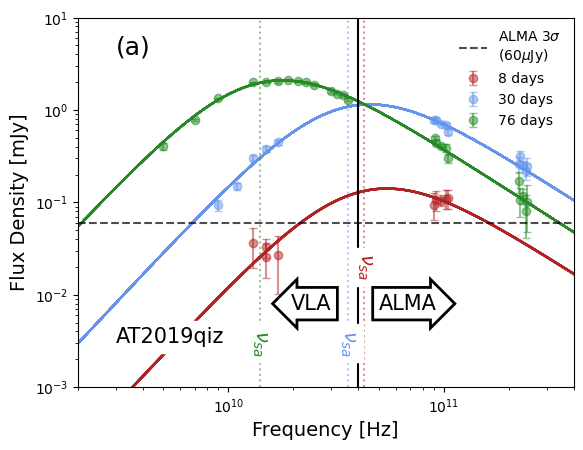

In [9]:
centervals = [8, 30, 76]
tols = [5, 5, 5]
locs = [2e-2, 3e-3, 3e-3]
theta_inits = [1, 10]
n = 1000
burnin = n//2
model = CustomB5_qiz #syncfit.models.B5
nkeep = 100
cols = ['firebrick', 'cornflowerblue', 'forestgreen']
p = 4

fig, ax = plt.subplots()

for val, tol, c, loc in zip(centervals, tols, cols, locs):

    ds = data[np.isclose(data.t, val, atol=tol)]

    lines = ax.errorbar(1e9*ds.Frequency, ds.FluxDensity, fmt='o', yerr=ds.FluxDensityErr, 
                label=f'{val} days', alpha=0.5, capsize=3, color=c)
    
    # with mm data
    sampler = syncfit.do_emcee(theta_inits, ds.Frequency.astype(float), ds.FluxDensity*1e3, 
                                ds.FluxDensityErr*1e3, plot=False, niter=n, model=model, fix_p=p)

    out, log_prob = syncfit.analysis.extract_output(sampler)
    nus = np.arange(1e8,5e12,1e7)  
    sed = model.SED
    best = out[np.argsort(log_prob)[-nkeep:]]
    cc = lines[-1][0].get_color()
    for o in best:
        res = sed(nus, p, *o)
        ax.plot(nus, res, alpha=0.1, linestyle='-', color=cc)

    nu_a = 10**syncfit.analysis.get_bounds(sampler, labels=['p', 'log F_v', 'log nu_a'],
                                           discard=n//2)[0][-1]

    ax.axvline(nu_a, linestyle=':', color=cc)
    ax.text(nu_a, loc, r'$\nu_{sa}$', fontsize=14, color=cc, ha='center', va='center',
            rotation=-90, alpha=1, backgroundcolor='w')
    
ax.set_ylabel(r'Flux Density [mJy]', fontsize=14)
ax.set_xlabel('Frequency [Hz]', fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.text(3e9, 3e-3, 'AT2019qiz', fontsize=15, backgroundcolor='w')
ax.text(3e9, 4, '(a)', fontsize=18, backgroundcolor='w')

ax.set_ylim(1e-3, 1e1)
ax.set_xlim(2e9, 4e11)

ax.axvline(40e9, color='k', linestyle='-')
ax.text(30e9, 8e-3, "VLA",
        ha="right", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="larrow,pad=0.3", lw=2, fc='w', ec='k')
       )
ax.text(50e9, 8e-3, "ALMA",
        ha="left", va="center", rotation=0, size=15,
        bbox=dict(boxstyle="rarrow,pad=0.3", lw=2, fc='w', ec='k')
       )

ax.axhline(60e-3, linestyle='--', color='k', alpha=0.7, label='ALMA 3$\sigma$ \n(60$\mu$Jy)')

ax.legend(loc='upper right', frameon=False)

fig.savefig('2019qiz-sed-plot.png', transparent=False, bbox_inches='tight')